# OFDM with QAM Modulation - Transmitter

Bit stream -> M-QAM -> OFDM -> Noise -> Visualizations 



In [28]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.io import savemat
import os
ifft_size = 720 # FFT size = number of subcarriers 
cp_length = 80
num_symbols = 20
mod_order = 16 # modulation order (e.g., 16-QAM)
num_active = 109 # number of active subcarriers 

Ld = ifft_size
Ls = Ld + cp_length 
dc_index = ifft_size // 2 
half = num_active // 2
active_subcarriers = list(range(dc_index - half, dc_index)) + \
                     list(range(dc_index + 1, dc_index + half + 1))


ifft_size = 720: This determines the total number of subcarriers (both active and inactive) in each OFDM symbol. 

You can think of this as the size of your frequency grid — you have 720 "slots" in the frequency domain.

cp_length = 80: Length of the cyclic prefix added to each OFDM symbol (used to combat ISI).

num_symbols = 20: This refers to the number of OFDM time-domain symbols you generate in total — i.e., how many different time samples (each one made from 720 subcarriers) you will create.

M-QAM: This tells us that each active subcarrier carries \(log_2(M)\) bits per OFDM symbol 

Think of it like a matrix:

- Each row is an OFDM symbol in time (20 total).
- Each column is a subcarrier (720 total, but maybe only ~109 are "active").

So we have 

$[720 subcarriers × 20 symbols]$

structure before applying IFFT + CP.

Each OFDM symbol uses the full set of subcarriers (but not all need to be modulated — often you zero-out the edges or DC).

Why 109 active subcarriers? 

The choice of 109 active subcarriers is arbitrary and design-dependent — it's not fixed by the IFFT size (720).

Even though your IFFT size is 720, not all subcarriers are used for data transmission.

DC Subcarrier (Center Frequency): The subcarrier at index 720/2 +1 = 361, corresponds to 0 Hz (DC), it is not used because it causes interference and no information is transmitted at 0 Hz.

Guard Bands: Subcarriers at the edges of the IFFT spectrum are usually zero-padded (i.e., set to 0) to prevent spectral leakage and simplify filtering. These are called guard subcarriers. This is especially important when OFDM signals are adjacent to other channels (e.g., LTE or WiFi).

Pilot Subcarriers (optional): Some subcarriers are used for channel estimation and synchronization — they don't carry data but help the receiver align and equalize.

\begin{array}{|l|c|l|}
\hline
\textbf{Region} & \textbf{Subcarrier Indices} & \textbf{Purpose} \\
\hline
\text{1. Guard (left)} & 1\text{ to }306 & \text{Zero-padded (guard)} \\
\text{2. Active (lower)} & 307\text{ to }360 & \text{QPSK data} \\
\text{3. DC} & 361 & \text{Explicitly nulled} \\
\text{4. Active (upper)} & 362\text{ to }415 & \text{QPSK data} \\
\text{5. Guard (right)} & 416\text{ to }720 & \text{Zero-padded (guard)} \\
\hline
\end{array}





### General M-QAM Mapping 

#### M-QAM Mapping

In **square M-QAM**, the constellation is a square grid:

* For **16-QAM**, the grid is $4 \times 4$
* For **64-QAM**, it's $8 \times 8$

That means:

* Half the bits control the **in-phase (I)** component
* Half control the **quadrature (Q)** component


#### 1. `bits_per_axis = bits_per_symbol // 2`

This divides the total bits per symbol equally between the **I** and **Q** axes.

| Modulation | bits\_per\_symbol | bits\_per\_axis |
| ---------- | ----------------- | --------------- |
| QPSK (4)   | 2                 | 1               |
| 16-QAM     | 4                 | 2               |
| 64-QAM     | 6                 | 3               |

So:

* Each **QAM symbol** = `bits_per_symbol` bits
* $2^{\text{bits\_per\_axis}}$ levels per axis


#### 2. `M_axis = sqrt(mod_order)`

This calculates the number of levels **per dimension** in the constellation.

| mod\_order | M\_axis |
| ---------- | ------- |
| 4          | 2       |
| 16         | 4       |
| 64         | 8       |

So for 16-QAM, each axis (I/Q) has 4 possible values (e.g., $-3, -1, +1, +3$)

---

#### 3. Splitting Bits into I and Q

```python
bits_I = symbols_bin[:, :bits_per_axis]   # First half of bits
bits_Q = symbols_bin[:, bits_per_axis:]   # Second half of bits
```

We're taking the `symbols_bin` matrix (shape: `[num_symbols, bits_per_symbol]`), and for each row:

* The **first half** goes to `bits_I`
* The **second half** goes to `bits_Q`

These are used to modulate:

* I: horizontal axis of constellation (real part)
* Q: vertical axis (imaginary part)

---

#### Example: 16-QAM

For one QAM symbol:

```python
bits = [1, 0, 1, 1]
```

```python
bits_I = [1, 0] → decimal 2 → I component
bits_Q = [1, 1] → decimal 3 → Q component
```

Then mapped to:

* $I = 2 \times 2 - 3 = +1$
* $Q = 2 \times 3 - 3 = +3$

Final complex symbol:

```python
qam_data = 1 + j*3
```



In [29]:
def generate_mqam_symbols(mod_order, num_active, num_symbols):
    
    bits_per_symbol = int(np.log2(mod_order))
    total_bits = num_active * num_symbols * bits_per_symbol
    bits = np.random.randint(0,2,total_bits) # generate random bits [low = 0, high = 2) = [0,1]
    symbol_bin = bits.reshape(-1,bits_per_symbol) # e.g, 4360 bits will be (1090,4) if log2(M) = 4
    # reshape(-1,x), automatically figures out how many rows are needed so each row has x columns 
    # QAM parameters: 
    bits_per_axis = bits_per_symbol // 2   # divide bits equally for I & Q
    M_axis = int(np.sqrt(mod_order)) # number of constellation points per axis 
    # split bits into I, Q parts: 
    bits_I = symbol_bin[:, :bits_per_axis] # Take I bits from each row 
    bits_Q = symbol_bin[:, bits_per_axis:] # Takes Q bits from each row 

    # Converting each row of array of binary bits into decimal (integer) value similar to bi2de() in matlab 
    def bin2dec(arr): 
        return arr.dot(1 << np.arange(arr.shape[-1]-1,-1,-1))
    
    I_indices = bin2dec(bits_I)
    Q_indices = bin2dec(bits_Q) 

    # Map to constellation points
    I_vals = 2*I_indices - (M_axis - 1)
    Q_vals = 2*Q_indices - (M_axis - 1)

    qam_data = I_vals + 1j*Q_vals 
    qam_data /= np.sqrt(np.mean(np.abs(qam_data)**2))

    return qam_data, bits 
    

In [30]:
qam_data, bits = generate_mqam_symbols(mod_order, num_active, num_symbols)
print("QAM symbols shape:", qam_data.shape)  

QAM symbols shape: (2180,)


#### Further Steps: 

1. Bit Stream Generation

2. Modulation groups every 2 bits → 1 complex symbol, Output: A stream of complex symbols.

3. Serial to parallel conversion:

    - Divide the complex symbol stream into blocks of size equal to the number of active subcarriers (e.g., 109).

    - These form frequency-domain vectors for each OFDM symbol.

4. Subcarrier mapping: 
Map each block of complex symbols to specific active subcarriers in the full IFFT grid (e.g., 720-point vector). Set unused subcarriers and DC to 0.

5. IFFT: Apply IFFT (e.g., 720-point) to each frequency-domain OFDM symbol to convert it into a time-domain signal.
Output: time-domain complex samples for each OFDM symbol.

6. Cyclic Prefix (CP) Addition: 
Copy the last cp_length samples of the IFFT output and prepend them to the symbol.
This helps with multipath channel resilience.

7. Parallel-to-Serial Conversion

    - Convert the CP-added symbols back into a serial stream for DAC transmission.
    OFDM Signal generation

    - OFDM divides the total channel bandwidth into multiple orthogonal subcarriers. Each subcarrier carries a portion of the data in parallel, making the system resilient to multipath fading and ISI.

Let:

    N: IFFT size (number of subcarriers)
    X[k]: Modulated symbol (e.g., QPSK, M-QAM) on the k-th subcarrier
    x[n]: Time-domain OFDM signal

$$x[n] = \frac{1}{\sqrt{N}} \sum_{k=0}^{N-1} X[k] \cdot e^{j\, \frac{2\,\pi \,k\,n}{N}}, \quad n = 0, 1, \dots, N-1
$$

Subcarrier Allocation and DC Nulling

Active subcarriers are chosen symmetrically around the center.

The DC subcarrier (at k = N/2) is set to zero to eliminate carrier leakage.

Guard bands are left unused to avoid spectral leakage into adjacent channels.

To combat Inter-Symbol Interference (ISI), a Cyclic Prefix of length  is added by copying the last samples of the time-domain symbol and appending them to the front.

$$
x_{\text{cp}}[n] =
\begin{cases}
x[n + N - L_{\text{CP}}], & 0 \leq n < L_{\text{CP}} \\
x[n - L_{\text{CP}}], & L_{\text{CP}} \leq n < N + L_{\text{CP}}
\end{cases}
$$

The total OFDM symbol length becomes 

$$L_s = N + L_{\text{CP}}
$$

The transmit signal is constructed by concatenating multiple CP-extended OFDM symbols:

$$x_{\text{total}}[n] = \left[ \text{CP}_1 + x_1[n],\ \text{CP}_2 + x_2[n],\ \dots \right]
$$

OFDM transmits data in parallel over multiple subcarriers, each modulated at a different frequency. It uses the orthogonality of sinusoids to pack them tightly together without interference.

BUT: generating multiple sinusoids manually would be complex.

Instead of manually modulating 109 carriers with QPSK and summing sinusoids, we use the Inverse Fast Fourier Transform (IFFT).

Each point in the frequency-domain vector you pass to the IFFT acts like the amplitude/phase of a subcarrier.

The IFFT outputs a superposition of all those subcarriers — a time-domain signal.

Think of OFDM as encoding frequency data, and then IFFT transforms it into the real-world time signal you transmit.



In [31]:
def generate_ofdm_signal(qam_data, ifft_size, cp_length, num_symbols, active_subcarriers, dc_index):
    num_active = len(active_subcarriers)
    symbol_matrix = np.zeros((num_symbols, ifft_size), dtype=complex)
    ofdm_signal = []

    for i in range(num_symbols):
        # Extract QAM symbols for this OFDM symbol
        idx_start = i * num_active
        idx_end = (i + 1) * num_active
        this_symbol = qam_data[idx_start:idx_end]

        # Map symbols to subcarriers
        freq_data = np.zeros(ifft_size, dtype=complex)
        freq_data[active_subcarriers] = this_symbol
        freq_data[dc_index] = 0  # Null DC

        # IFFT to get time-domain OFDM symbol
        time_data = np.fft.ifft(freq_data) * np.sqrt(ifft_size)
        symbol_matrix[i, :] = freq_data

        # Add cyclic prefix
        cp = time_data[-cp_length:]
        ofdm_symbol = np.concatenate((cp, time_data))
        ofdm_signal.append(ofdm_symbol)

    # Concatenate all symbols into one 1D signal
    ofdm_signal = np.concatenate(ofdm_signal)

    # Normalize to unit average power
    ofdm_signal /= np.sqrt(np.mean(np.abs(ofdm_signal) ** 2))

    return ofdm_signal, symbol_matrix


In [32]:
ofdm_signal, symbol_matrix = generate_ofdm_signal(
    qam_data=qam_data,
    ifft_size=ifft_size,
    cp_length=cp_length,
    num_symbols=num_symbols,
    active_subcarriers=active_subcarriers,  
    dc_index=dc_index
)

Note: 
At this point, we have a baseband complex-valued signal, which is:

$$s_{\text{baseband}} (t) = I(t) + jQ(t)$$

To transmit it over a real-valued RF channel, we need to convert it to a passband (RF) signal using IQ modulation:

IQ Modulation (Digital-to-Analog + RF Upconversion): 

generate the real RF signal as:

$$s(t) = I(t) . cos(2\pi\, f_c t) - Q(t) . sin(2\pi f_ct)
$$

This maps the complex baseband signal to a real-valued RF signal centered at carrier frequency 

#### Noise Modeling: Additive White Gaussian Noise (AWGN)

AWGN simulates channel impairments. It is added with a controlled Signal-to-Noise Ratio (SNR):

Target SNR in dB:

$$SNR_{\text{dB}} = 10 \log_{10} \left( \frac{P_{\text{signal}}}{P_{\text{noise}}}\right)
$$

Convert to linear scale:

$$SNR_{\text{linear}} = 10^{\text{SNR}_{\text{dB}}/10}
$$

Noise power:

$$P_{\text{noise}} = \frac{P_{\text{signal}}}{\text{SNR}_{\text{linear}}}
$$

AWGN samples:

$$w[n] = \sqrt{\frac{P_{\text{noise}}}{2}} \cdot \left( \mathcal{N}(0,1) + j \mathcal{N}(0,1) \right)
$$

Final noisy signal:

$$x_{\text{noisy}}[n] = x_{\text{total}}[n] + w[n]
$$

#### Noise Padding

To emulate practical signal capture scenarios (e.g., over-the-air or burst transmissions), noise-only regions are added before and after the useful signal.

$$x_{\text{final}}[n] = \left[ w_{\text{before}},\ x_{\text{noisy}}[n],\ w_{\text{after}} \right]
$$

This helps in testing synchronization, thresholding, and signal detection techniques.



In [33]:
def add_noise_and_pad(ofdm_signal, noise_snr_db, left_pad, right_pad, save_path='OFDM_Rx_Signal.mat'):
    # Step 1: Compute signal power and noise power
    signal_power = np.mean(np.abs(ofdm_signal)**2)
    noise_power = signal_power / (10**(noise_snr_db / 10))

    # Step 2: Add complex Gaussian noise (broadband in-band)
    noise_std = np.sqrt(noise_power / 2)
    inband_noise = noise_std * (np.random.randn(len(ofdm_signal)) + 1j * np.random.randn(len(ofdm_signal)))
    ofdm_signal_noisy = ofdm_signal + inband_noise

    # Step 3: Add noise padding
    noise_before = noise_std * (np.random.randn(left_pad) + 1j * np.random.randn(left_pad))
    noise_after  = noise_std * (np.random.randn(right_pad) + 1j * np.random.randn(right_pad))

    # Step 4: Final concatenated signal
    final_signal = np.concatenate([noise_before, ofdm_signal_noisy, noise_after])

    # Step 5: Save to .mat file
    savemat(save_path, {'final_signal': final_signal})

    return final_signal


In [34]:
final_signal = add_noise_and_pad(ofdm_signal, noise_snr_db=25, left_pad=600, right_pad=1000)


### Visualization 

In [35]:
def ofdm_demodulate(ofdm_signal_noisy, ifft_size, cp_length):
    Ld = ifft_size
    Ls = Ld + cp_length
    num_symbols_actual = len(ofdm_signal_noisy) // Ls

    # Step 1: Reshape the noisy signal into symbols
    X_matrix = ofdm_signal_noisy[:num_symbols_actual * Ls].reshape((num_symbols_actual, Ls))

    # Step 2: Remove CP
    X_no_cp = X_matrix[:, cp_length:]  # shape: [num_symbols, Ld]

    # Step 3: FFT and shift
    X_fft = np.fft.fft(X_no_cp, axis=1)
    # X_fft = np.fft.fftshift(np.fft.fft(X_no_cp, axis=1), axes=1)
    # Step 4: Power matrix
    power_matrix = np.abs(X_fft) ** 2  # shape: [num_symbols, Ld]

    # Step 5 (Optional): Pad to full IFFT size if Ld < ifft_size
    full_power = np.zeros((num_symbols_actual, ifft_size))
    full_power[:, :Ld] = power_matrix

    return full_power, X_fft, power_matrix


In [36]:
full_power, X_fft, power_matrix = ofdm_demodulate(
    ofdm_signal_noisy=final_signal[600:-1000],  # remove the noise padding before/after
    ifft_size=ifft_size,
    cp_length=cp_length
)

Text(0.5, 1.0, 'Received OFDM Signal with Noise')

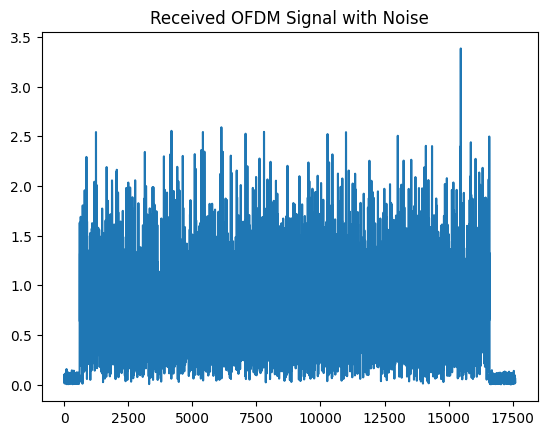

In [37]:
plt.figure(1) 
plt.plot(abs(final_signal))
plt.title('Received OFDM Signal with Noise')

In [38]:
def plot_subcarrier_power(power_matrix, ifft_size, num_symbols_actual):
    power_db = 10 * np.log10(power_matrix + 1e-12)  # avoid log(0)

    plt.figure(figsize=(12, 5))
    extent = [0, num_symbols_actual, 0, ifft_size]

    # Use jet colormap for better contrast
    im = plt.imshow(
        power_db.T,
        aspect='auto',
        extent=extent,
        origin='lower',
        cmap='jet',
        vmin=np.max(power_db) - 40,
        vmax=np.max(power_db)
    )

    plt.title('Subcarrier Power Spectrum (dB)', fontsize=14)
    plt.xlabel('OFDM Symbol Index', fontsize=12)
    plt.ylabel('Subcarrier Index', fontsize=12)
    plt.colorbar(im, label='Power (dB)')

    plt.grid(False)
    plt.tight_layout()
    plt.show()



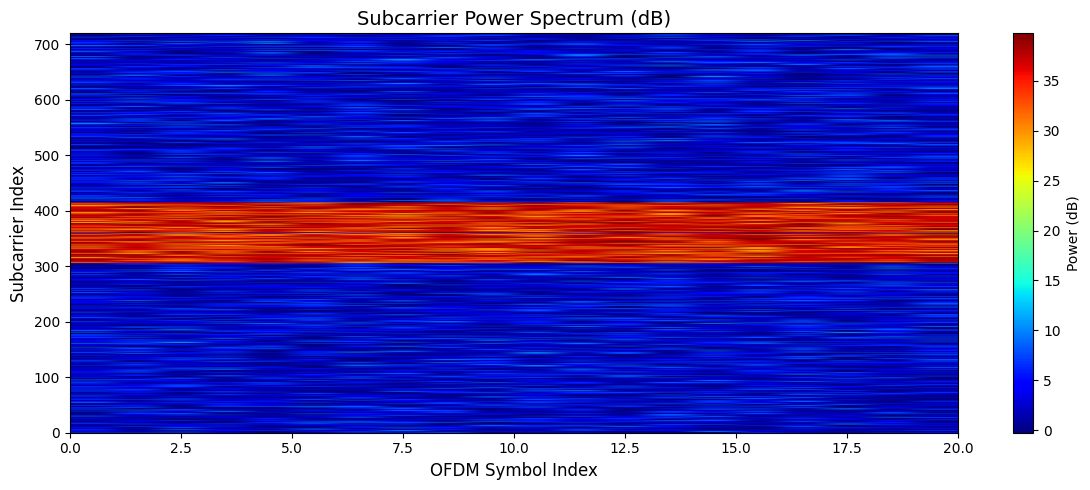

In [39]:
plot_subcarrier_power(full_power, ifft_size=720, num_symbols_actual=20)


In [40]:
def plot_autocorrelation(signal, max_lag=None):
    N = len(signal)
    if max_lag is None:
        max_lag = N // 2

    # Compute full autocorrelation (normalized)
    corr = np.correlate(signal, signal, mode='full')  # length: 2N - 1
    lags = np.arange(-N + 1, N)
    corr = corr / np.max(np.abs(corr))  # Normalize to max=1 (coeff mode)

    # Keep only positive lags
    positive_lags = lags >= 0
    lags_positive = lags[positive_lags][:max_lag]
    Rxx_positive = corr[positive_lags][:max_lag]

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(lags_positive, np.abs(Rxx_positive))
    plt.title('Autocorrelation of the Received Signal')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation Coefficient')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


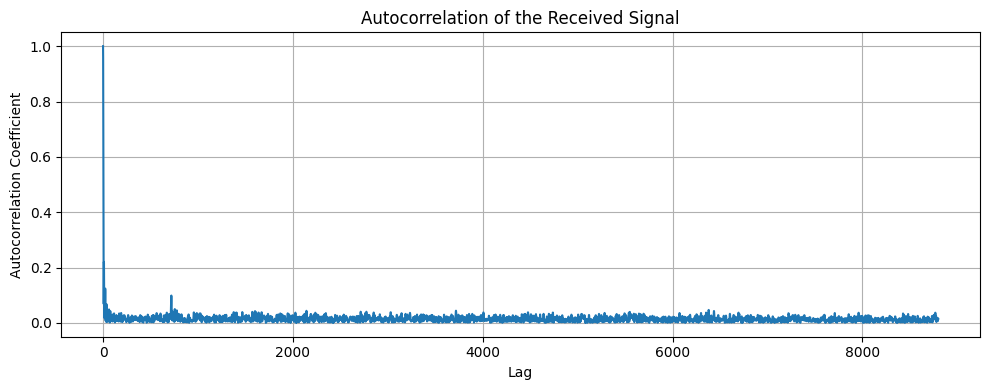

In [41]:
plot_autocorrelation(final_signal)


In [42]:
def plot_psd_strictly_symmetric(power_matrix, ifft_size, fs=1.0):
    """
    Plot PSD with guaranteed symmetry around 0 Hz.
    """
    # Step 1: Average power over OFDM symbols
    avg_power = np.mean(power_matrix, axis=0)

    # Step 2: Shift power so DC is centered
    psd_shifted = np.fft.fftshift(avg_power) / (fs / ifft_size)
    psd_db = 10 * np.log10(psd_shifted + 1e-12)

    # Step 3: Create symmetric frequency axis (avoids asymmetry from fftfreq)
    if ifft_size % 2 == 0:
        # Even size
        freq_axis = np.linspace(-fs/2, fs/2, ifft_size, endpoint=False)
    else:
        # Odd size: ensure 0 Hz is centered
        freq_axis = np.linspace(-fs/2, fs/2, ifft_size)

    # Step 4: Plot
    plt.figure(figsize=(10, 4))
    plt.plot(freq_axis, psd_db, linewidth=1.2)
    plt.title('Power Spectral Density (dB/Hz)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD (dB/Hz)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


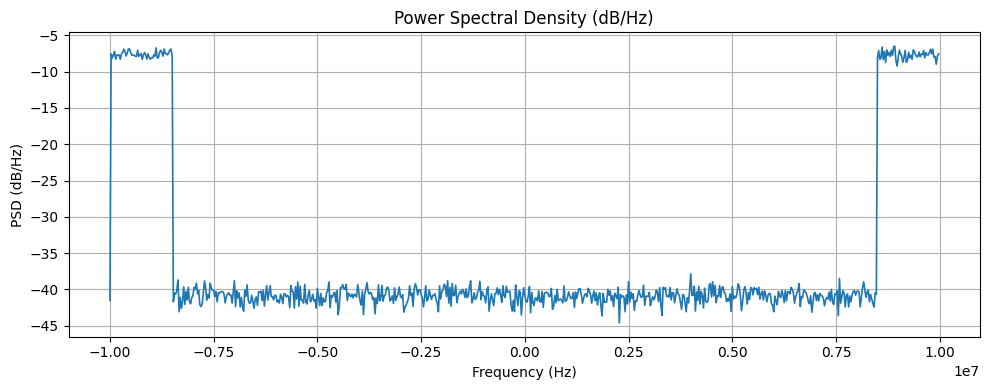

In [43]:
plot_psd_strictly_symmetric(power_matrix, ifft_size=720, fs=20e6)


In [44]:
def plot_constellation(X_fft, active_subcarriers):
    # Step 1: Extract symbols from active subcarriers (avoid DC, guard bands)
    rx_constellation = X_fft[:, active_subcarriers]  # shape: [num_symbols, num_active]

    # Step 2: Flatten to 1D array
    rx_symbols_flat = rx_constellation.flatten()

    # Step 3: Determine scaling for axis limits
    avg_power = np.mean(np.abs(rx_symbols_flat)**2)
    scale = 2 * np.sqrt(avg_power)

    # Step 4: Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(rx_symbols_flat.real, rx_symbols_flat.imag, s=10, c='blue', alpha=0.6)
    plt.title('QPSK Constellation after OFDM Demodulation')
    plt.xlabel('In-phase')
    plt.ylabel('Quadrature')
    plt.grid(True)
    plt.axis('equal')
    plt.xlim([-scale, scale])
    plt.ylim([-scale, scale])
    plt.tight_layout()
    plt.show()


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


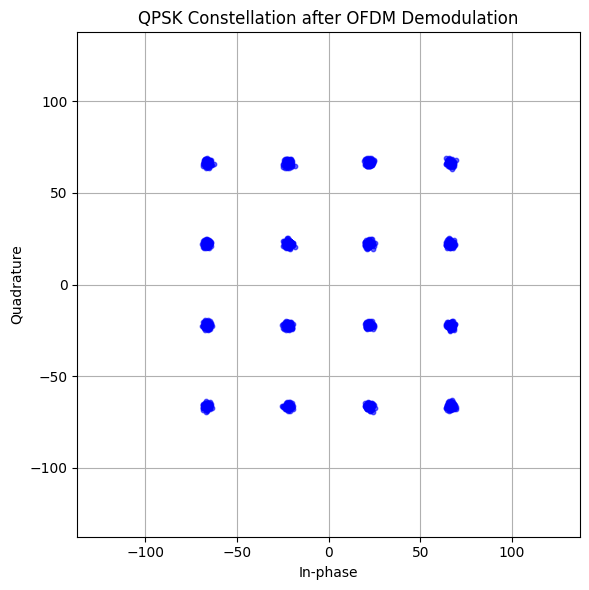

In [45]:
plot_constellation(X_fft, active_subcarriers)


---

# Receiver 

## OFDM Signal Processing (Receiver Side) 

A complete **baseband receiver-side analysis** of an OFDM signal:

* Synchronization via energy threshold and correlation
* CP detection to validate symbol structure
* FFT demodulation for symbol extraction
* Visualization of constellation and power spectrum
* Subcarrier diagnostics for quality inspection

Unkown parameters: 

- CP length
- FFT length
- Symbol start index
- Symbol stop index
- Null subcarriers

### 1. **Signal Preprocessing**

* Load the received signal (input data)
* Define OFDM parameters:
  * Estimate symbol start index 
  * Estimate symbol stop index 
  * Estimate cyclic prefix length for symbols 
  * Estimate total number of symbols

### 2. **Autocorrelation for Rough Symbol Start**

* Compute autocorrelation of the received signal to identify repeating structure.
* Detect the **initial start index** of OFDM symbols based on energy thresholding.
* Use a moving window to refine this estimate.


### 3. **Cyclic Prefix (CP) Correlation-Based Detection**

* Sweep over candidate start indices around the rough estimate.
* For each, check the correlation between CP and end of symbols.
* Select the start index that gives the **maximum average CP correlation**.


### 4. **Symbol Extraction and FFT**

* From the chosen start index, extract all OFDM symbols.
* Remove the cyclic prefix from each.
* Perform FFT on each symbol to transform to the frequency domain.
* Apply `fftshift` to center the DC subcarrier.


### 5. **Constellation Plotting**

* Flatten all subcarriers from all symbols into a single array.
* Plot real vs. imaginary values of subcarriers to visualize:

  * Identify modulation type (e.g., QPSK, QAM)
  * Analyze signal quality and distortions

### 6. **Subcarrier Power Analysis**

* Calculate power per subcarrier for each symbol.
* Identify **low-power (null or attenuated)** subcarriers.
* Use `stem` plots to highlight which subcarriers fall below a threshold (e.g., power < threshold).
* Overplot known null subcarriers for verification.


---

# 1. Signal Preprocessing 

dict_keys(['__header__', '__version__', '__globals__', 'final_signal'])


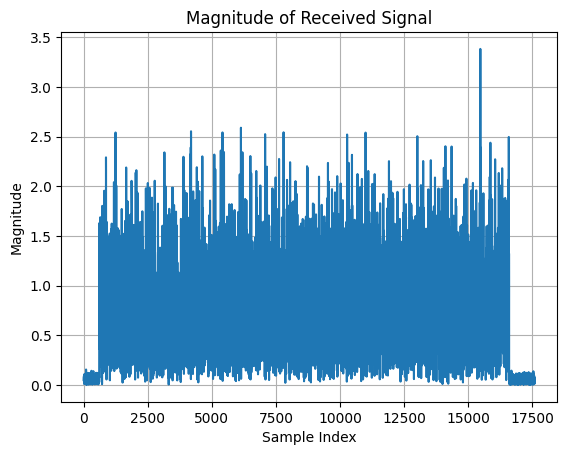

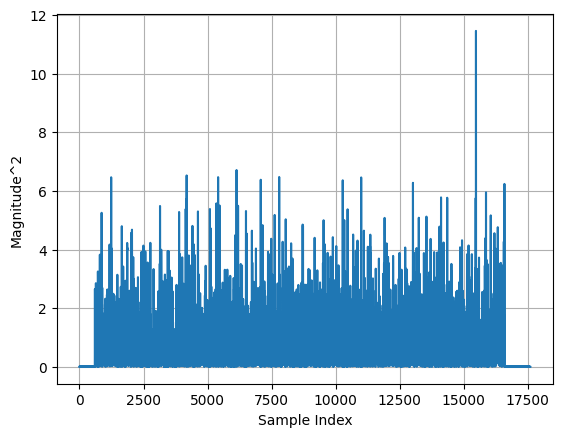

In [46]:
import scipy.io

# Load the received signal
Received = scipy.io.loadmat('OFDM_Rx_Signal.mat')

print(Received.keys())
rx_signal = Received['final_signal']  
rx_signal = rx_signal.squeeze()  # Convert (n,1) to (n,) if needed

plt.figure()
plt.plot(np.abs(rx_signal))  # Magnitude
plt.title('Magnitude of Received Signal')
plt.xlabel('Sample Index')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(np.abs(rx_signal)**2)  # Magnitude
plt.xlabel('Sample Index')
plt.ylabel('Magnitude^2')
plt.grid(True)
plt.show()


## 2. Autocorrelation Analysis of Received Signal

Computing **autocorrelation** of the received signal to analyze its periodic structure and estimate symbol length.

### Autocorrelation Function

For a real-valued discrete signal $x[n]$, the autocorrelation function $R_{xx}[k]$ is defined as:

$$
R_{xx}[k] = \sum_{n} x[n] \cdot x[n+k]
$$

Where:

* $k$ is the **lag** (shift),
* For negative $k$, we evaluate $x[n] \cdot x[n - |k|]$,
* For normalization (`'coeff'`), we divide by the maximum value of $|R_{xx}[k]|$.

### Why Autocorrelation?

* Peaks in the autocorrelation function at non-zero lags can indicate **periodic patterns**.
* In digital communications, repeated symbol structures create peaks at multiples of **symbol length**.
* Here, a peak at lag = x, suggests the symbol duration is approximately **x samples**.


* Repeated peaks suggest periodicity in the received signal.
* If a peak occurs at lag ≈ x, it implies a **symbol duration** of x samples:

## Start Index Detection Based on Noise Threshold

The **start of the useful signal** in a received waveform based on power thresholding

- Estimate background noise power from the samples.
- Detect where the signal power significantly exceeds the noise.
- Mark and highlight a region around the detected start index.


### Noise Power Estimation

If roughly N samples are noisy samples at the beginning of received signal, then:

$$
P_{\text{noise}} = \frac{1}{N} \sum_{n=1}^{N} |x[n]|^2
$$

Where:

- \( x[n] \) is the received signal,
- \( |x[n]| \) is the magnitude (for complex signals).

### Threshold-Based Detection

We detect the **first index** where the signal power exceeds a multiple of the noise power:

$$
\text{start\_index} = \min \left\{ n : |x[n]|^2 > \text{Threshold} \cdot P_{\text{noise}} \right\}
$$



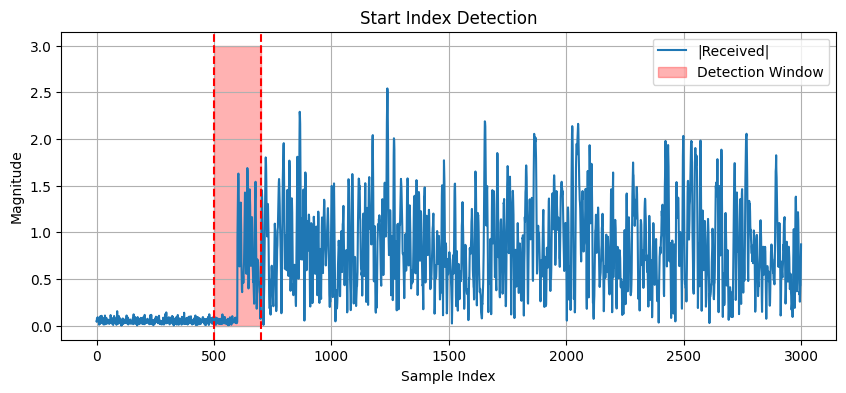

Start Index of Signal: 600


In [47]:
noise1_power = np.mean(np.abs(rx_signal[:700])**2) 
Threshold = 0.3 # the threshold factor is empirically chosen

# Find the start index where signal power exceeds noise threshold
ind = np.where(np.abs(rx_signal)**2 > Threshold * noise1_power)[0]
start_index = ind[0] if len(ind) > 0 else None

# Plot up to 5×start_index
plt.figure(figsize=(10, 4))
plt.plot(np.abs(rx_signal[:5*start_index]), label='|Received|')
plt.axvline(start_index - 100, color='r', linestyle='--')
plt.axvline(start_index + 100, color='r', linestyle='--')

# Shade the region from (start_index - 100) to (start_index + 100)
x_shade = [start_index - 100, start_index + 100, start_index + 100, start_index - 100]
y_shade = [0, 0, 3, 3]  # Adjust height if needed based on your signal

plt.fill(x_shade, y_shade, color='red', alpha=0.3, label='Detection Window')
plt.title("Start Index Detection")
plt.xlabel("Sample Index")
plt.ylabel("Magnitude")
plt.grid(True)
plt.legend()
plt.show()
print("Start Index of Signal:", start_index)

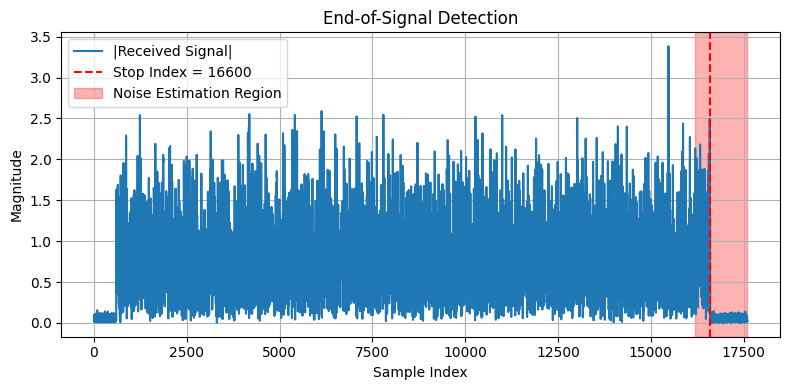

Stop Index: 16600


In [48]:
def detect_end_index(rx_signal, noise_est_start, threshold_factor, plot=True):
    # Estimate noise power from the known tail region
    noise_power = np.mean(np.abs(rx_signal[noise_est_start:])**2)
    threshold = threshold_factor * noise_power
    power = np.abs(rx_signal)**2

    # Set where to start scanning for stop index (e.g., after halfway point)
    search_start = noise_est_start  # or dynamic: len(rx_signal) // 2
    window_len = 400

    stop_index = None
    for i in range(search_start, len(rx_signal) - window_len):
        window = power[i:i+window_len]
        if np.all(window < threshold):
            stop_index = i
            break

    # Plot
    if plot:
        plt.figure(figsize=(8, 4))
        plt.plot(np.abs(rx_signal), label='|Received Signal|')
        if stop_index:
            plt.axvline(stop_index, color='r', linestyle='--', label=f'Stop Index = {stop_index}')
        plt.axvspan(noise_est_start, len(rx_signal), color='red', alpha=0.3, label='Noise Estimation Region')
        plt.title('End-of-Signal Detection')
        plt.xlabel('Sample Index')
        plt.ylabel('Magnitude')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return stop_index


stop_index = detect_end_index(rx_signal, noise_est_start=16200, threshold_factor=1)
print("Stop Index:", stop_index)



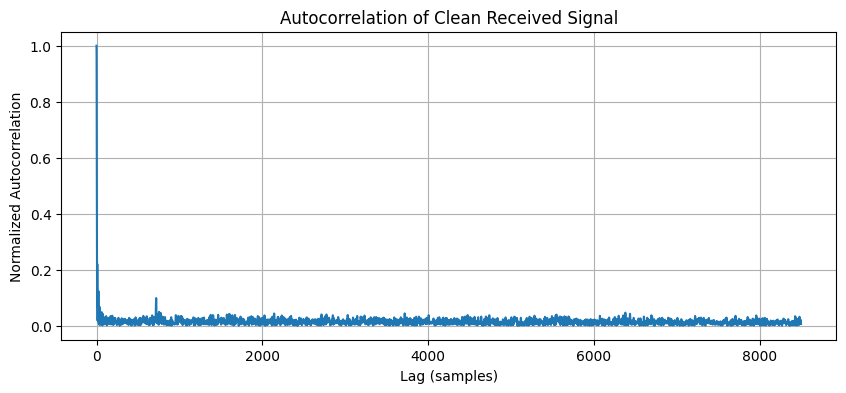

Detected peak lags: [  9 720]
Estimated Symbol Duration: 720 samples


In [49]:
from scipy.signal import find_peaks
rx_clean = rx_signal[start_index:]  # Remove noise before OFDM signal
N = len(rx_clean)
max_lag = N // 2

# Autocorrelation
Rxx_full = np.correlate(rx_clean, rx_clean, mode='full')
lags = np.arange(-N + 1, N)
Rxx_full = Rxx_full / np.max(np.abs(Rxx_full))  # Normalize

# Take positive lags
mid_index = len(Rxx_full) // 2
Rxx_positive = Rxx_full[mid_index:(mid_index + max_lag + 1)]
lags_positive = lags[mid_index:(mid_index + max_lag + 1)]

# Plot
plt.figure(figsize=(10, 4))
plt.plot(lags_positive, np.abs(Rxx_positive))
plt.title('Autocorrelation of Clean Received Signal')
plt.xlabel('Lag (samples)')
plt.ylabel('Normalized Autocorrelation')
plt.grid(True)
plt.show()

# Find peaks
peaks, _ = find_peaks(np.abs(Rxx_positive), height=0.05, distance=300)
peak_lags = lags_positive[peaks]
print("Detected peak lags:", peak_lags)

# Estimate symbol duration
if len(peak_lags) >= 2:
    diffs = np.diff(peak_lags)
    # symbol_duration_est = int(np.median(diffs))
    symbol_duration_est = peak_lags[1]
    print("Estimated Symbol Duration:", symbol_duration_est, "samples")
else:
    print("Not enough peaks found to estimate symbol duration.")


# 3. Cyclic Prefix (CP) Correlation-Based Detection

Implementing a correlation-based search to **refine the start index** of an OFDM-like signal by detecting the **CP** structure within a predefined range.

To scan a window of possible start indices near the initial estimate and find the one that:

- Maximizes **CP autocorrelation**, indicating correct symbol alignment.
- Helps identify where **OFDM symbols** begin reliably.

### OFDM Symbol Structure

- Each symbol has a **CP** prepended.
- CP is a copy of the last part of the symbol.
- This helps mitigate inter-symbol interference (ISI) and aids synchronization.

If  \(L_d\)  is the symbol length and \(L_{cp}\) is the CP length, the total symbol duration is:

$$
T_d = L_{cp} + L_d
$$



### CP Correlation Metric

To detect the symbol start, we compute the **correlation** between:

The **first \( L_{cp} \)** samples of the symbol, and  
The **last \( L_{cp} \)** samples of the same symbol.

$$
\text{Correlation}(L_{cp}) = \left| \sum_{n=0}^{L_{cp}-1} x[n] \cdot x^*[T_d - L_{cp} + n] \right|
$$

This is computed for several symbols and averaged across symbols to smooth the estimate.


### Assumptions

- Each OFDM-like symbol has length `Ld`
- The total symbol duration is `Td = L_cp + Ld`, where `L_cp` is the cyclic prefix.
- The signal starts approximately at sample 398.


For a candidate CP length `L_cp`, and a symbol starting at index \( i \), the **cyclic prefix correlation** is:

$$
Correlation(L_{cp}, i) = | sum( conj(x[0:L_{cp}]) * x[-L_{cp}:] ) |
$$

Where:

- `x` is the signal segment of one symbol of length `Td = L_cp + Ld`,

- `x[0:L_cp]` is the start (prefix),

- `x[-L_cp:]` is the end (suffix),

- The correlation magnitude evaluates cyclic similarity.

### Algorithm Steps

1. **Scan candidate start indices** from `start_index - 100` to `start_index + 100`.

2. For each candidate `j`, extract the signal: `x = rx_signal[j:]`.

3. For each possible CP length 
            $$L_{cp} \in [1, L_d/4]$$

    - Loop over 10 symbols (`i = 1` to `10`).
    - For each symbol, extract the CP and tail, then compute their correlation.


4. Store the **maximum average correlation** across CP lengths for each candidate index.

5. Identify the index with **maximum CP alignment**.



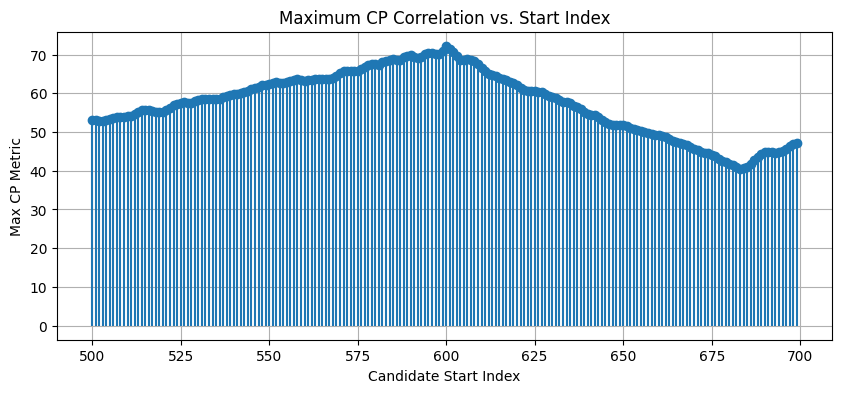

Maximum CP Metric = 72.27 at index = 600


In [50]:
Signal = rx_signal
Ld = symbol_duration_est
mm = [] # maximum metric for CP
search_range = range(start_index - 100, start_index + 100)

# Loop over potential start indices around estimated start_index
for j in search_range:
    x = Signal[j:]
    c = np.zeros((Ld // 4, 10))  # Rows: possible CP lengths, Cols: symbols (3 to 18)

    for i in range(1, 10):  # symbol indices
        for cp_len in range(1, Ld // 4 + 1):
            Td = cp_len + Ld
            start = (i - 1) * Td
            end_ = i * Td
            if end_ > len(x):
                continue
            x1 = x[start:end_]
            c[cp_len - 1, i] = np.abs(np.sum(np.conj(x1[:cp_len]) * x1[-cp_len:]))

    cp_avg = np.mean(c, axis=1)
    mm.append(np.max(cp_avg))

j_range = list(search_range)
mm = np.array(mm)

plt.figure(figsize=(10, 4))
plt.stem(j_range, mm, linefmt='C0-', markerfmt='C0o', basefmt=" ")
plt.title("Maximum CP Correlation vs. Start Index")
plt.xlabel("Candidate Start Index")
plt.ylabel("Max CP Metric")
plt.grid(True)
plt.show()

# Best start
mm_max_idx = j_range[np.argmax(mm)]
print(f"Maximum CP Metric = {np.max(mm):.2f} at index = {mm_max_idx}")

# print("prvious start index:", start_index)
# print("new start index:", mm_max_idx)
# start_index = mm_max_idx + 1


### Cyclic Prefix Estimation for Fixed Start Index

Examining the structure of an OFDM-like signal starting from a fixed `start_index` to evaluate the correlation between the cyclic prefix and the end of each symbol.

- Detect if the signal exhibits repeated cyclic structure.
- Plot correlation metrics per symbol.
- Average correlation results to validate CP length estimation.


### Algorithm

1. For each symbol index `i = 1` to `10`:

   - Try all possible CP lengths from 1 to `Ld / 4`.

   - Extract the full symbol of length `Td = L_cp + Ld`.

   - Compute correlation between prefix and suffix.

   - Store result in a matrix `c`.

2. Plot correlation profile for each symbol:

   - X-axis: CP length candidate
   - Y-axis: Correlation magnitude

3. Average the CP correlation results over all symbols:

   - This helps remove noise and verify stable structure.

4. Report maximum averaged correlation:

   - Indicates strongest CP candidate for alignment.



This analysis helps visually verify whether a **cyclic prefix structure** exists and if the starting point is aligned with the symbol boundary.

- Sharp peaks in correlation plots confirm cyclic structure.
- High average correlation across multiple symbols suggests reliable CP detection.


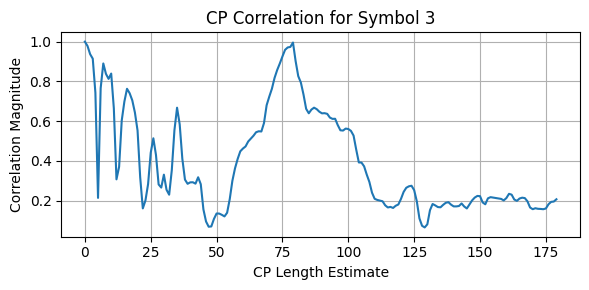

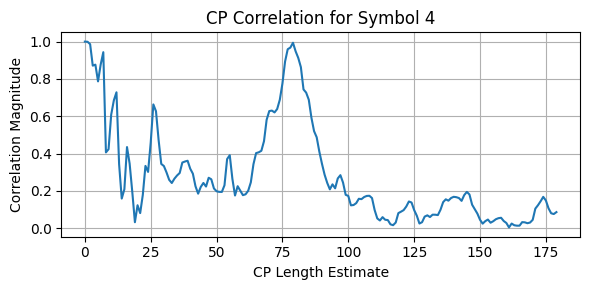

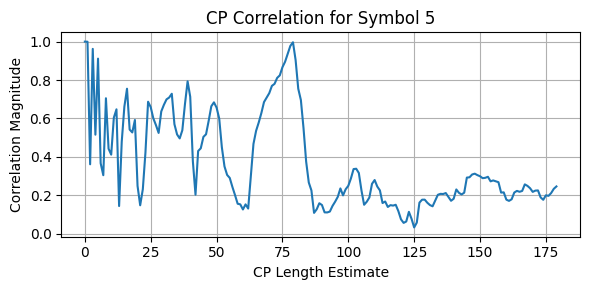

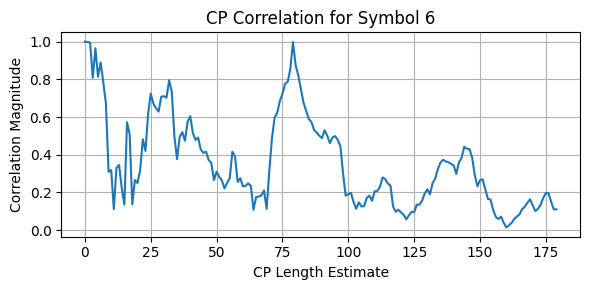

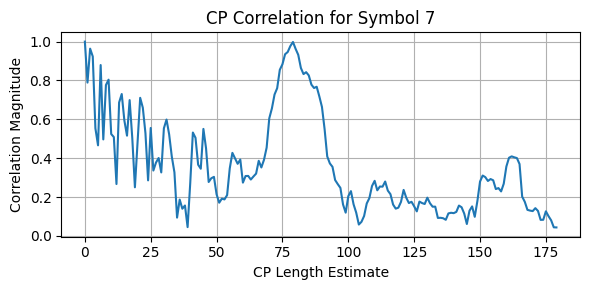

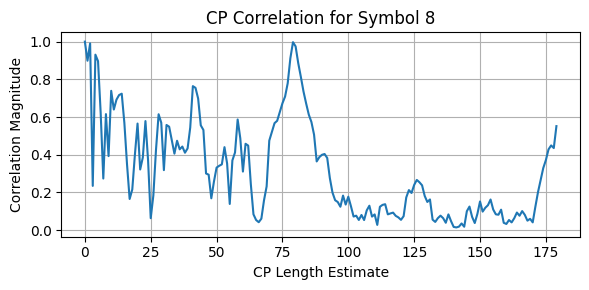

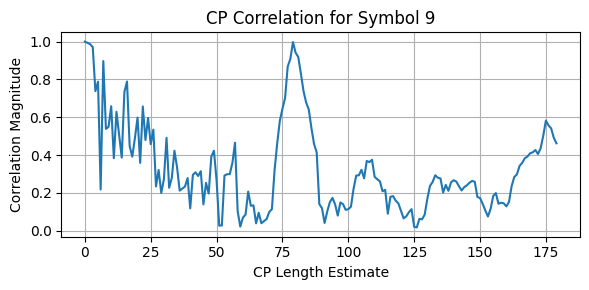

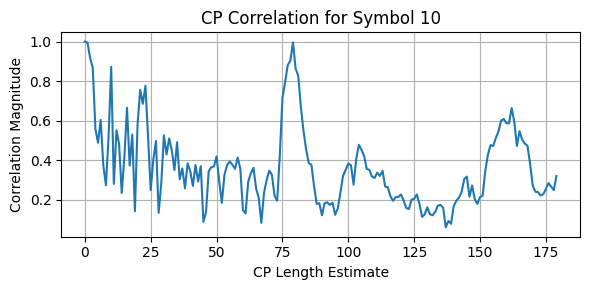

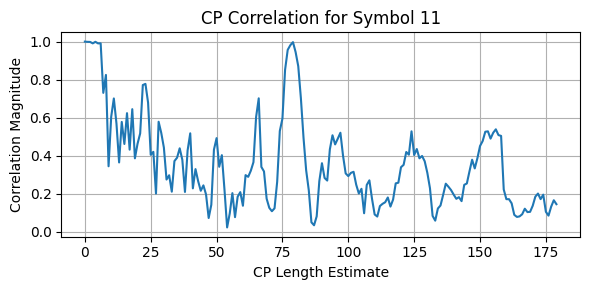

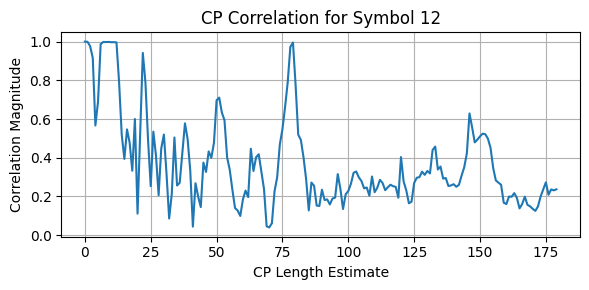

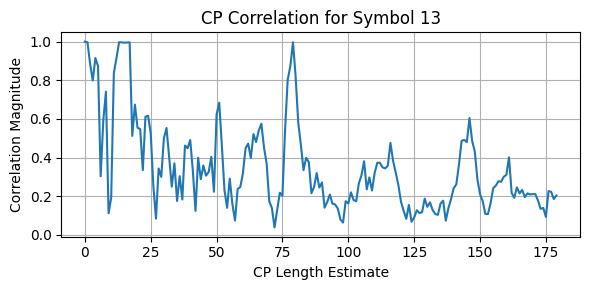

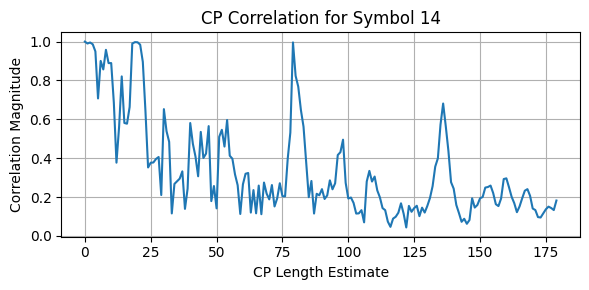

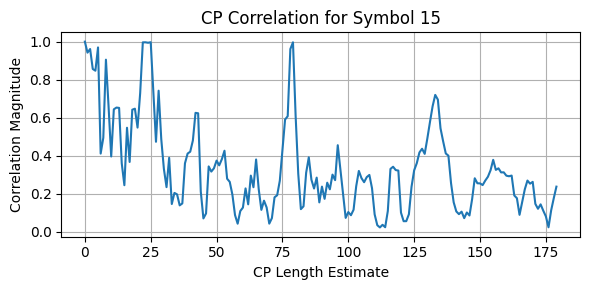

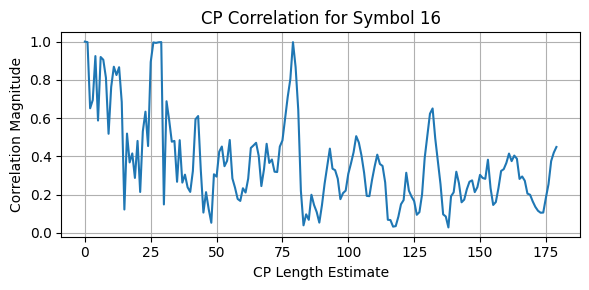

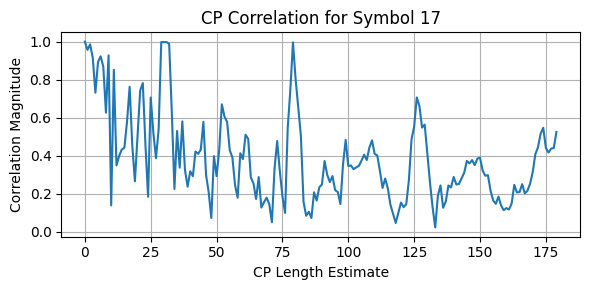

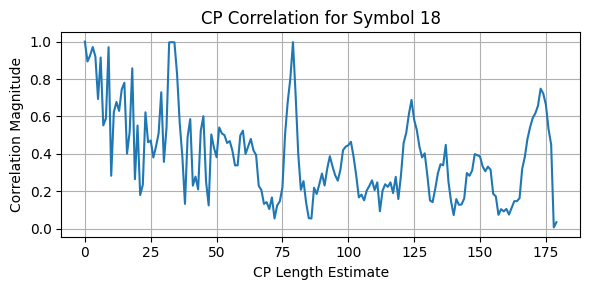

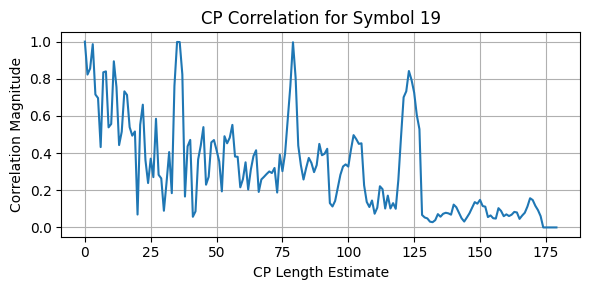

Max averaged CP correlation: 0.8947
Estimated CP Length: 80 samples
Edtimated Symbol Length, Ld:  640
Estimated Symbol Length + CP, Td:  720


In [51]:
x = Signal[start_index:]
c = np.zeros((Ld // 4, 19))  # Rows: CP lengths, Cols: symbol instances 

# Process each symbol index from 3 to 20
for i in range(3, 20):
    for cp_length_est in range(1, Ld // 4 + 1):
        Td = cp_length_est + Ld  # Total duration of one symbol with CP
        start = (i - 1) * Td
        end_ = i * Td
        if end_ > len(x):  # Safety check
            continue
        x1 = x[start:end_]
        a = x1[:cp_length_est]
        b = x1[-cp_length_est:]
        numer = np.sum(np.conj(a) * b)
        denom = np.sqrt(np.sum(np.abs(a)**2) * np.sum(np.abs(b)**2))
        c[cp_length_est - 1, i-1] = np.abs(numer / denom)

    # Plot each symbol's CP correlation profile
    plt.figure(figsize=(6, 3))
    plt.plot(c[:, i - 1])
    plt.title(f"CP Correlation for Symbol {i}")
    plt.xlabel("CP Length Estimate")
    plt.ylabel("Correlation Magnitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Average CP correlation across symbols
cp_avg = np.mean(c[:, :20], axis=1)  # Use only columns 0–7 (symbols 1 to 8)

# Store maximum correlation (for this fixed start_index)
mm_val = np.max(cp_avg)
print(f"Max averaged CP correlation: {mm_val:.4f}")
# Find CP length corresponding to maximum average correlation

min_cp = 4  # Avoid CP = 1–3
search_range = np.arange(min_cp, Ld // 4 + 1)
valid_cp_avg = cp_avg[min_cp - 1:]  # cp_avg[3:] if min_cp = 4
cp_index = np.argmax(valid_cp_avg)
estimated_cp_length = search_range[cp_index]
print(f"Estimated CP Length: {estimated_cp_length} samples")
print("Edtimated Symbol Length, Ld: ", symbol_duration_est - estimated_cp_length)
print("Estimated Symbol Length + CP, Td: ", symbol_duration_est)



## 5. OFDM Symbol Extraction and Constellation Plotting

This process analyzes an OFDM-like signal by segmenting it into symbols, removing CP, performing FFT, and plotting the constellation diagram to visualize modulation characteristics.

- Support symbol extraction at different downsampling factors `k`.
- Apply CP removal and FFT per symbol.
- Flatten the frequency-domain symbols into one array.
- Plot the resulting constellation.


### Steps

1. **Symbol Slicing**

   From the signal $x[n]$, we extract an integer number of symbols:

   $$
   \text{total\_length} = \text{num\_symbols} \times L_s
   $$

   Then reshape into matrix $x_{\text{symbols}} \in \mathbb{C}^{L_s \times N_{\text{sym}}}$.

2. **CP Removal**

   Remove first `Lcp` samples of each symbol:

   $$
   x_{\text{no\_cp}} = x_{\text{symbols}}[L_{\text{cp}}:, :]
   $$

3. **FFT per Symbol**

   Apply FFT to each column (symbol):

   $$
   X_k = \text{FFT}(x_{\text{no\_cp}}[:, k])
   $$

4. **FFT Shift**

   Center the DC component using `fftshift`.

5. **Flatten Constellation**

   Flatten all subcarriers from all symbols:

   $$
   \text{constellation\_points} = \text{flatten}(X_{\text{symbols}})
   $$

Processing for k = 1
  Lcp = 80, Ld = 720, Ls = 800
 num_symbols = 20
  Start index = 600


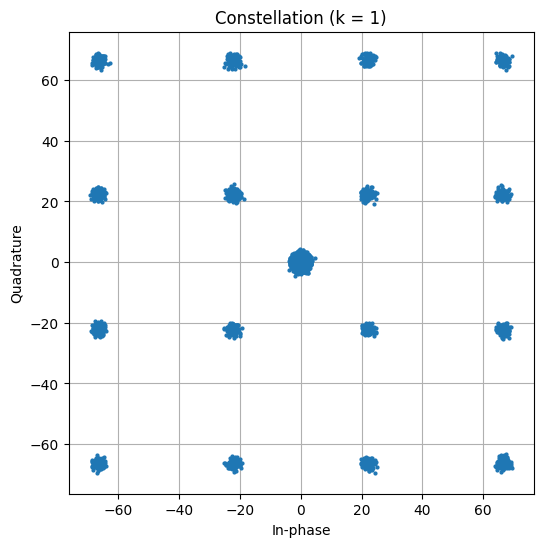

In [52]:
x_raw = rx_signal

# Optional: visualize multiple downsampling factors
for k in [1]:  # You can extend to [1, 2, 4, 5, 8, 10, 16, 20, 40]
    print(f"Processing for k = {k}")

    Lcp = int(estimated_cp_length/k)
    Ld = int(symbol_duration_est/k)
    Ls = Lcp + Ld  # Total symbol length
    print(f"  Lcp = {Lcp}, Ld = {Ld}, Ls = {Ls}")
    # print("start_index :", start_index)
    # print("stop index :", stop_index)
    signal_length = stop_index - start_index; #Total samples in signal
    num_symbols = int(signal_length / Ls); # Only complete symbols
    print(f" num_symbols = {num_symbols}")

    # Optional: downsampling
    x = x_raw[::k]
    for indd in [start_index]:
        print(f"  Start index = {indd}")
        x = x_raw[indd:]
        N = len(x)
        # num_symbols = len(x) // Ls  # Fixed manually
        total_length = num_symbols * Ls

        if total_length > N:
            print("  Not enough data to extract symbols.")
            continue

        x_truncated = x[:total_length]

        # Reshape into symbols: shape = (Ls, num_symbols)
        x_symbols = x_truncated.reshape((Ls, num_symbols), order='F')

        # Remove CP from each symbol (result: shape = (Ld, num_symbols))
        x_no_cp = x_symbols[Lcp:, :]

        # Perform FFT on each column (along rows)
        X_symbols = np.fft.fft(x_no_cp, n=Ld, axis=0)

        # Shift frequency spectrum (zero-freq to center)
        X_symbols = np.fft.fftshift(X_symbols, axes=0)

        # Flatten to 1D vector
        constellation_points = X_symbols.flatten()

        # Plot the constellation
        plt.figure(figsize=(6, 6))
        plt.plot(np.real(constellation_points), np.imag(constellation_points), 'o', markersize=2)
        plt.title(f'Constellation (k = {k})')
        plt.xlabel('In-phase')
        plt.ylabel('Quadrature')
        plt.grid(True)
        plt.axis('equal')
        plt.show()



## 6. OFDM Demodulation and Constellation Plotting

### Signal Segmentation and FFT

Implementation of an OFDM demodulation process that uses multiple start indices to extract frequency-domain constellation points.

- Refine symbol synchronization using multiple candidate start indices.
- Demodulate OFDM-like symbols by removing the cyclic prefix and performing FFT.
- Visualize constellation points for quality analysis of the modulation scheme.

### Parameters

   - **Downsampling factor (k):** Determines resolution. Only `k = 1` is used in this run.
   - **Cyclic Prefix (CP) length:** `Lcp = Lcp / k`
   - **Data symbol length (Ld):** `Ld = Lc / k`
   - **Total symbol length:** `Ls = Lcp + Ld`
   - **Start indices tested:** `indd ∈ [start_index+1, start_index+2, start_index+3]`
   - **Number of symbols:** Fixed at 21



1. **Start Index Selection**

   - For each `indd` in the range `[start_index+1, start_index+2, start_index+3]`, the signal is processed from that point onward.
   - This tests alignment sensitivity.

2. **Signal Truncation**

   - Extract a fixed number of complete OFDM symbols (21 symbols of length `Ls`).
   - The signal is reshaped into a 2D matrix of size `(Ls, num_symbols)`.

3. **Cyclic Prefix Removal**

   - For each symbol, remove the first `Lcp` samples.
   - Resulting matrix has shape `(Ld, num_symbols)`.

4. **FFT Processing**

   - Apply FFT to each symbol column to transform into the frequency domain.
   - Use `fftshift` to center the DC component.

5. **Flatten and Plot**

   - Flatten the matrix into a 1D array of constellation points.
   - Plot the real vs. imaginary parts to visualize modulation (e.g., QPSK, 16-QAM).




Processing with k=1, Lcp=80, Ld=720, Ls=800
 num_symbols = 20
  Processing start index: 599


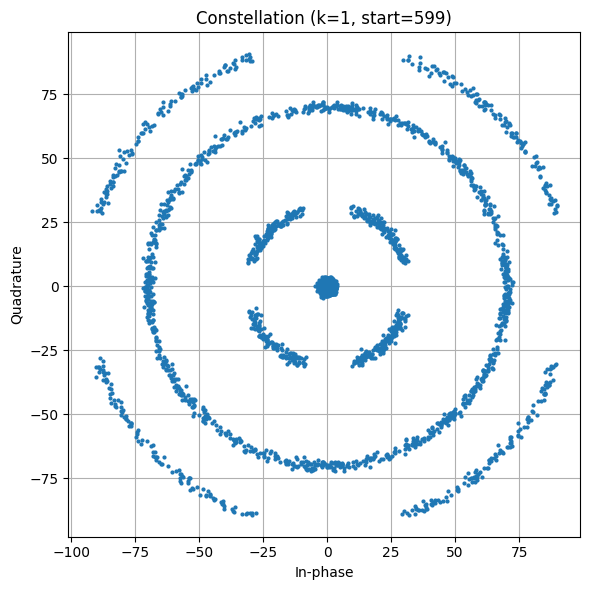

  Processing start index: 600


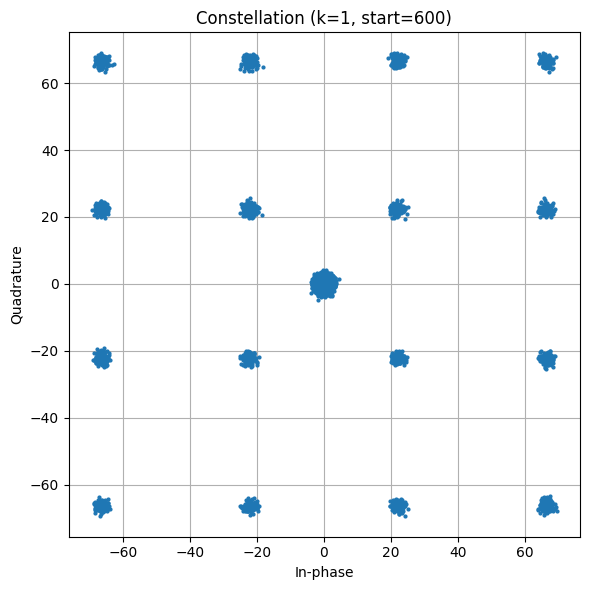

  Processing start index: 601


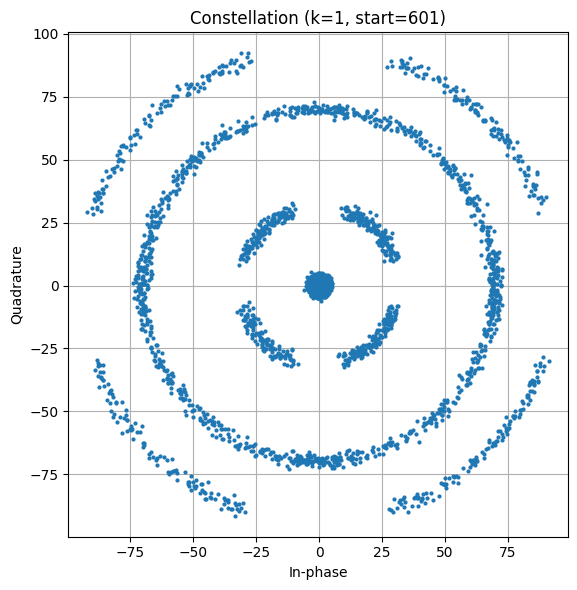

  Processing start index: 602


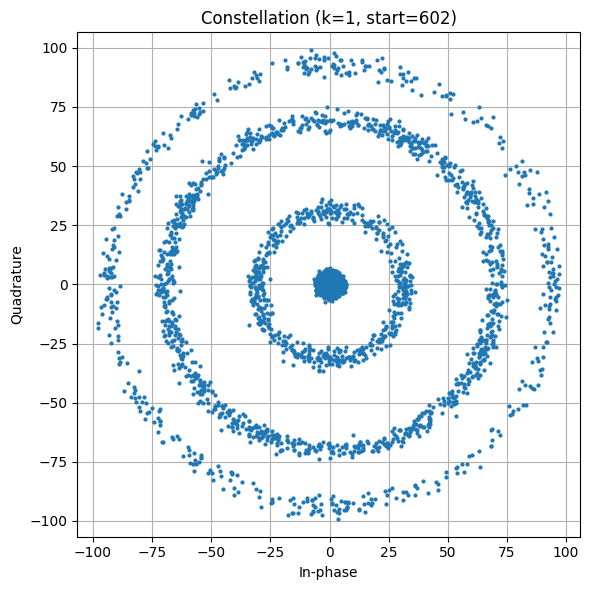

In [53]:
for k in [1]:
    Lcp = int(Lcp / k)  # Adjusted CP length
    Ld = int(Ld / k)  # Adjusted data (useful symbol) length
    Ls = Lcp + Ld      # Total OFDM symbol length
    print(f"\nProcessing with k={k}, Lcp={Lcp}, Ld={Ld}, Ls={Ls}")
    print(f" num_symbols = {num_symbols}")

    # Downsampled version (optional)
    x_down = x_raw[::k]

    for indd in range(start_index-1, start_index + 3):  
        print(f"  Processing start index: {indd}")
        x = x_raw[indd:]
        N = len(x)
        total_length = num_symbols * Ls

        if total_length > N:
            print("  Skipping: Not enough data.")
            continue

        # Truncate signal to complete symbols
        x_truncated = x[:total_length]

        # Reshape into (Ls, num_symbols) matrix
        x_symbols = x_truncated.reshape((Ls, num_symbols), order='F')

        # Remove CP from each symbol → shape (Ld, num_symbols)
        x_no_cp = x_symbols[Lcp:, :]

        # Apply FFT on each symbol (column-wise)
        X_symbols = np.fft.fft(x_no_cp, n=Ld, axis=0)

        # Shift zero-frequency to center
        X_symbols = np.fft.fftshift(X_symbols, axes=0)

        # Flatten to form 1D list of constellation points
        constellation_points = X_symbols.flatten()

        # Plot
        plt.figure(figsize=(6, 6))
        plt.plot(np.real(constellation_points), np.imag(constellation_points), 'o', markersize=2)
        plt.title(f'Constellation (k={k}, start={indd})')
        plt.xlabel('In-phase')
        plt.ylabel('Quadrature')
        plt.grid(True)
        plt.axis('equal')
        plt.tight_layout()
        plt.show()



## 7. Subcarrier Power Analysis 

### OFDM Demodulation with Subcarrier Power Analysis

OFDM demodulation on a received signal with:

- Cyclic prefix removal
- FFT and FFT shift
- Power thresholding on subcarriers
- Visualization of low-power carriers and frequency-domain content


- Identify weak subcarriers (e.g., due to fading or zero-padding)
- Plot per-symbol power spectrum
- Visualize constellation of demodulated symbols



### Parameters

- **Downsampling factor (k):** 1
- **Cyclic prefix (CP):** `Lcp = Lcp / k`
- **Data symbol length:** `Ld = Ld / k`
- **Total symbol length:** `Ls = Lcp + Ld`
- **Start index (`indd`)**: `start_index`
- **Number of symbols processed**: estimated_symbols


### Processing Steps

1. **Signal Extraction**
   - Slice signal from `indd` onward.
   - Truncate to `total_length = num_symbols * Ls`.

2. **Reshape into Symbols**
   - Reshape into a matrix: `x_symbols ∈ ℂ^{Ls × num_symbols}`.
   - Remove CP: `x_no_cp = x_symbols[Lcp:, :]`.

3. **Frequency-Domain Transformation**
   - Perform FFT on each column (symbol).
   - Apply `fftshift` to center DC component.

4. **Low-Power Subcarrier Detection**
   - Compute magnitude squared of each FFT bin.
   - Identify entries where power `< 20`.
   - Plot with a **stem plot**:
     - X-axis: Symbol index
     - Y-axis: Subcarrier index


5. **Per-Symbol Power Spectrum**
   - Plot power of all subcarriers across symbols 1 to estimated_symbols.
   - Each curve shows the subcarrier power for one OFDM symbol.

6. **Constellation Visualization**
   - Flatten the FFT matrix.
   - Plot real vs. imaginary components of all subcarriers to assess:
     - Modulation type
     - Noise and phase distortion


## Use Cases

- Check spectral nulls or filter effects
- Evaluate subcarrier energy distribution
- Validate modulation under different timing assumptions

   - Extend `k` to other values for resolution studies.
   - Adjust power threshold (`< 20`) for more or fewer detected subcarriers.



Processing with k=1, Lcp=80, Ld=720, Ls=800


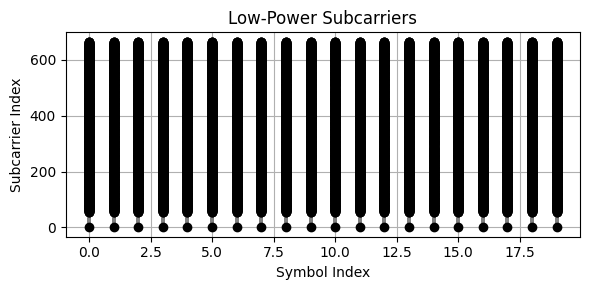

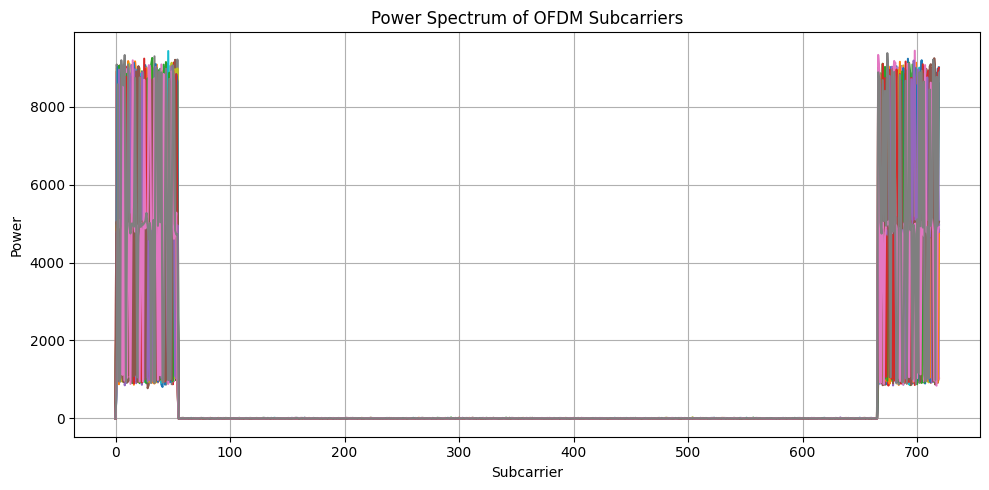

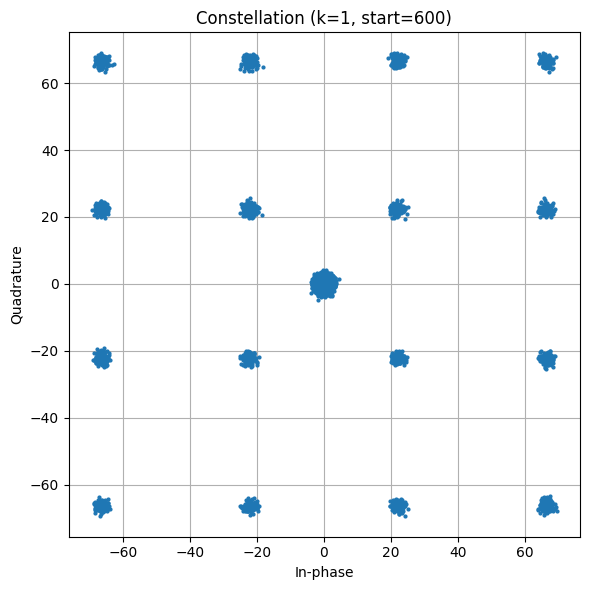

In [54]:
for k in [1]:

    print(f"\nProcessing with k={k}, Lcp={Lcp}, Ld={Ld}, Ls={Ls}")

    x_down = x_raw[::k]

    for indd in [start_index]:
        x = x_raw[indd:]
        N = len(x)
        # num_symbols = estimated_symbols
        total_length = num_symbols * Ls

        if total_length > N:
            print("Not enough data for full symbols")
            continue

        x_truncated = x[:total_length]
        x_symbols = x_truncated.reshape((Ls, num_symbols), order='F')
        x_no_cp = x_symbols[Lcp:, :]  # shape: (Ld, num_symbols)

        # FFT + fftshift
        X_symbols = np.fft.fftshift(np.fft.fft(x_no_cp, n=Ld, axis=0), axes=0)

        # Detect low-power subcarriers (|X|^2 < 20)
        magnitude_squared = np.abs(X_symbols)**2
        rows, cols = np.where(magnitude_squared < 20)

        # Stem plot of low-power subcarriers
        plt.figure(figsize=(6, 3))
        plt.stem(cols, rows, linefmt='gray', markerfmt='ko', basefmt=' ')
        plt.title('Low-Power Subcarriers')
        plt.xlabel('Symbol Index')
        plt.ylabel('Subcarrier Index')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Per-symbol power spectrum
        plt.figure(figsize=(10, 5))
        for l in range(2, num_symbols): 
            plt.plot(range(Ld), magnitude_squared[:, l])
        plt.xlabel('Subcarrier')
        plt.ylabel('Power')
        plt.title('Power Spectrum of OFDM Subcarriers')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Flatten for constellation plot
        constellation_points = X_symbols.flatten()

        # Plot constellation
        plt.figure(figsize=(6, 6))
        plt.plot(np.real(constellation_points), np.imag(constellation_points), 'o', markersize=2)
        plt.title(f'Constellation (k={k}, start={indd})')
        plt.xlabel('In-phase')
        plt.ylabel('Quadrature')
        plt.grid(True)
        plt.axis('equal')
        plt.tight_layout()
        plt.show()

### Possible Cause of the Central Cluster: 

#### 1. DC subcarrier 

Noise and channel effects can cause DC bin to accumulate energy at the receiver. 

#### 2. Inactive or zeroed subcarriers: 

Many subcarriers are intentionally zeroed (guard bands) 
After passing through a channel (and added noise), those subcarriers can have small non-zero values which cluster zero. 

We must plot only the active subcarriers. 

#### 3. Noise Leakage: 

If SNR is moderate, noise leaks into zeroed bins and we'll see a noisy zero-energy cluster around 0,0

#### 4. Receiver demodulating blindly: 

If receiver blindly demodulates all 720 FFT outputs, we'll naturally get a lot of low-energy noisy points, especially at inactive bins. 




---
---
---


### Realistic Channel Models

More realistic environments:

* **Multipath fading**: Add Rayleigh or Rician fading (`scipy.signal.convolve` or tap delay line).
* **Doppler spread**: For mobile scenarios, apply time-varying channel impulse responses.
* **Frequency offset & phase noise**: Model oscillator mismatch and jitter.
* **Timing offset & jitter**: Add sample delays and timing estimation error.

---

### Synchronization Mechanisms

Real receivers implement:

* **Timing synchronization** (e.g., using cyclic prefix autocorrelation or Schmidl-Cox algorithm).
* **Frequency offset correction**.
* **Frame detection** (using preamble sequences like Zadoff-Chu or PN sequences).

---

### Channel Estimation & Equalization

Instead of assuming perfect channel knowledge:

* Insert **pilot symbols** or use **training sequences**.
* Implement **LS (Least Squares)** or **MMSE equalization**.
* Plot **channel frequency response** and estimate SNR per subcarrier.

---

### Performance Metrics & Visualization

* BER vs. SNR (you’re doing this already).
* **EVM (Error Vector Magnitude)**.
* **Constellation diagram before/after equalization**.
* **Spectrogram or PSD of transmitted signal**.

---


### Adding Forward Error Correction (FEC)

Industry systems always use FEC:

* Add **convolutional coding** (with `commpy`), **LDPC**, or **Turbo codes**.
* Use **soft-decision decoding** and integrate with BER evaluation.

---

### Hardware-Aware Constraints

* Quantization: Add ADC/DAC effects (bit depth).
* Clipping & PAPR: Add non-linearities and evaluate Peak-to-Average Power Ratio (PAPR).
* Power normalization across symbols.

---

### Exporting to SDR / Real-Time

* Generate `.wav` files or IQ samples for use in **GNU Radio**, **SDR hardware**, or **Simulink**.
* Use `pyserial` or `SoapySDR` if moving toward embedded/hardware.

---

### Example Goal:

> **End-to-End OFDM Tx/Rx with multipath fading, synchronization, pilot-aided channel estimation, FEC, and BER vs. SNR analysis — all modular and ready for SDR testing.**



---
# Multi-path Fading Channel (Rayleigh Fading)
    
In realistic wireless environments, transmitted signals often encounter multiple reflections, scatterings, and diffractions before reaching the receiver. These **multipath components** interfere with each other, resulting in **fading**, a major phenomenon in wireless communication systems.

When no **line-of-sight (LOS)** path exists and there are many randomly phased multipath components, the channel is modeled as a **Rayleigh fading channel**.

The **baseband-equivalent received signal** $y[n]$ under a discrete-time multipath Rayleigh fading channel with **$L$** taps is given by:

$$
y[n] = \sum_{\ell=0}^{L-1} h[\ell] \cdot x[n - \ell] + w[n]
$$

where:

* $x[n]$: Transmitted signal (complex baseband)
* $h[\ell]$: Channel impulse response coefficient of the $\ell$-th path
* $L$: Number of multipath taps
* $w[n]$: Additive white Gaussian noise (AWGN)


### Channel Impulse Response $h[\ell]$

Each tap $h[\ell]$ is modeled as a **complex Gaussian random variable**:

$$
h[\ell] \sim \mathcal{CN}(0, \sigma_\ell^2)
$$

where $\sigma_\ell^2$ is the power of the $\ell$-th tap. 

This means:

$$
h[\ell] = h_{\text{real}}[\ell] + j \cdot h_{\text{imag}}[\ell]
$$

where:

$$
h_{\text{real}}[\ell] \sim \mathcal{N}\left(0, \frac{\sigma_\ell^2}{2} \right), \quad
h_{\text{imag}}[\ell] \sim \mathcal{N}\left(0, \frac{\sigma_\ell^2}{2} \right)
$$

This ensures that the total power is:

$$
\mathbb{E}[|h[\ell]|^2] = \frac{\sigma_\ell^2}{2} + \frac{\sigma_\ell^2}{2} = \sigma_\ell^2
$$

### Probability Density Function (PDF) of $h_{\text{real}}[\ell]$

$$
f_{h_{\text{real}}}(x) = \frac{1}{\sqrt{2\pi \cdot \sigma_\ell^2 / 2}} \cdot \exp\left( -\frac{x^2}{2 \cdot \sigma_\ell^2 / 2} \right)
= \frac{1}{\sqrt{\pi \sigma_\ell^2}} \cdot \exp\left( -\frac{x^2}{\sigma_\ell^2} \right)
$$

The same form holds for $h_{\text{imag}}[\ell]$, due to symmetry.


### Magnitude Distribution

The magnitude $|h[\ell]|$ follows a **Rayleigh distribution** (since both components are i.i.d. $\mathcal{N}(0, \sigma_\ell^2/2)$):

$$
f_{|h|}(r) = \frac{r}{\sigma_\ell^2} \exp\left( -\frac{r^2}{2 \cdot \sigma_\ell^2} \right), \quad r \geq 0
$$

This is why we call the fading **Rayleigh** fading — even though the components are Gaussian, the magnitude is Rayleigh-distributed.


A common power profile is **exponential decay**, representing stronger early paths and weaker delayed reflections:

$$
\sigma_\ell^2 = \frac{e^{-\alpha \ell}}{\sum_{k=0}^{L-1} e^{-\alpha k}}
$$

* $\alpha$: Decay rate parameter
* This normalization ensures total power $\sum_\ell \sigma_\ell^2 = 1$

| Decay Factor $\alpha$ | Interpretation                            | Delay Profile Shape         |
| --------------------- | ----------------------------------------- | --------------------------- |
| $\alpha = 0$          | All taps have equal power (flat profile)  | Uniform / constant power    |
| $\alpha = 0.3$ to $1$ | Moderate decay — power fades with delay   | Realistic indoor models     |
| $\alpha > 1.5$        | Sharp decay — most energy in first tap(s) | Short-delay dominated paths |
| $\alpha \to \infty$   | Only first tap has power                  | Approaches flat fading      |


#### **Typical Values in Practice**

* **Indoor Office/LOS**:
  $\alpha \approx 0.5$ to $1.0$
  (few strong reflections)

* **Urban Microcell/NLOS**:
  $\alpha \approx 0.3$ to $0.8$
  (more rich scattering)

* **Vehicular Channels** (e.g., 802.11p or 3GPP):
  May use pre-defined tap powers instead of exponential, but exponential model with $\alpha \approx 0.7$–$1.5$ can approximate them.


#### Example: $L = 5$ taps, $\alpha = 0.7$

$$
\begin{align*}
\sigma_0^2 &\propto e^{-0 \cdot 0.7} = 1 \\
\sigma_1^2 &\propto e^{-1 \cdot 0.7} \approx 0.497 \\
\sigma_2^2 &\propto e^{-2 \cdot 0.7} \approx 0.247 \\
\sigma_3^2 &\propto e^{-3 \cdot 0.7} \approx 0.123 \\
\sigma_4^2 &\propto e^{-4 \cdot 0.7} \approx 0.061
\end{align*}
$$

Then normalize so that $\sum \sigma_\ell^2 = 1$


### Convolution in Time Domain

The fading is applied by **convolution** between the transmit signal $x[n]$ and the channel $h[\ell]$:

$$
y[n] = (x * h)[n] + w[n]
$$

In python, this is computed using:

```python
np.convolve(signal, h, mode='full')[:len(signal)]
```

### AWGN Noise

After fading, **additive white Gaussian noise** is added to simulate thermal or front-end noise. For a target SNR $\gamma_{\text{dB}}$, the noise power is:

$$
P_{\text{noise}} = \frac{P_{\text{signal}}}{10^{\gamma_{\text{dB}} / 10}}
$$

The noise vector $w[n]$ is generated as:

$$
w[n] = \mathcal{N}(0, \sigma^2) + j \cdot \mathcal{N}(0, \sigma^2), \quad \text{where } \sigma^2 = \frac{P_{\text{noise}}}{2}
$$

### Notes:

* Using more taps, **frequency-selective fading** can be simulated.
* Increasing decay factor $\alpha$ results in shorter delay spread.
* Flat fading is a special case when $L = 1$.

    

In [88]:
def apply_multipath_fading(signal, num_taps=3, alpha_rayleigh=0.7, snr_db=None,fs=1.0):
    """
    Apply Rayleigh multipath fading with exponential power decay.

    Parameters:
    - signal: Transmitted baseband signal (1D numpy array)
    - num_taps: Number of Rayleigh multipath taps (L)
    - alpha_rayleigh: Exponential decay rate for tap powers (typical: 0.3–1.0)
    - snr_db: Additive white Gaussian noise level in dB (optional)

    Returns:
    - faded_signal: Signal after Rayleigh fading (and AWGN if specified)
    - h: Channel impulse response (complex numpy array of length `num_taps`)
    """
    # Compute exponential power delay profile
    tap_powers = np.exp(-alpha_rayleigh * np.arange(num_taps))
    tap_powers /= np.sum(tap_powers)  # Normalize total power to 1

    # Generate complex Rayleigh fading taps
    h_real = np.random.randn(num_taps) * np.sqrt(tap_powers / 2)
    h_imag = np.random.randn(num_taps) * np.sqrt(tap_powers / 2)
    h = h_real + 1j * h_imag

    # Convolve signal with channel impulse response
    faded_signal = np.convolve(signal, h, mode='full')[:len(signal)]

    # Optional: Add AWGN based on target SNR
    if snr_db is not None:
        signal_power = np.mean(np.abs(faded_signal)**2)
        noise_power = signal_power / (10 ** (snr_db / 10))
        noise_std = np.sqrt(noise_power / 2)
        noise = noise_std * (np.random.randn(len(faded_signal)) + 1j * np.random.randn(len(faded_signal)))
        faded_signal += noise

    N = len(signal)
    t = np.arange(N) / fs

    plt.figure(figsize=(12, 6))
    plt.subplot(3, 1, 1)
    plt.plot(t, signal.real, label='Real')
    plt.title("faded_signal")
    plt.ylabel('Real')
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot(t, signal.imag, label='Imag', color='orange')
    plt.ylabel('Imaginary')
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.plot(t, np.abs(signal), label='Magnitude', color='green')
    plt.ylabel('Magnitude')
    plt.xlabel('Time (samples)' if fs == 1.0 else 'Time (s)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    plt.stem(np.arange(num_taps), tap_powers)
    plt.title("Exponential Tap Power Decay")
    plt.xlabel("Tap Index")
    plt.ylabel("Power")
    plt.grid(True)
    plt.show()

    return faded_signal, h


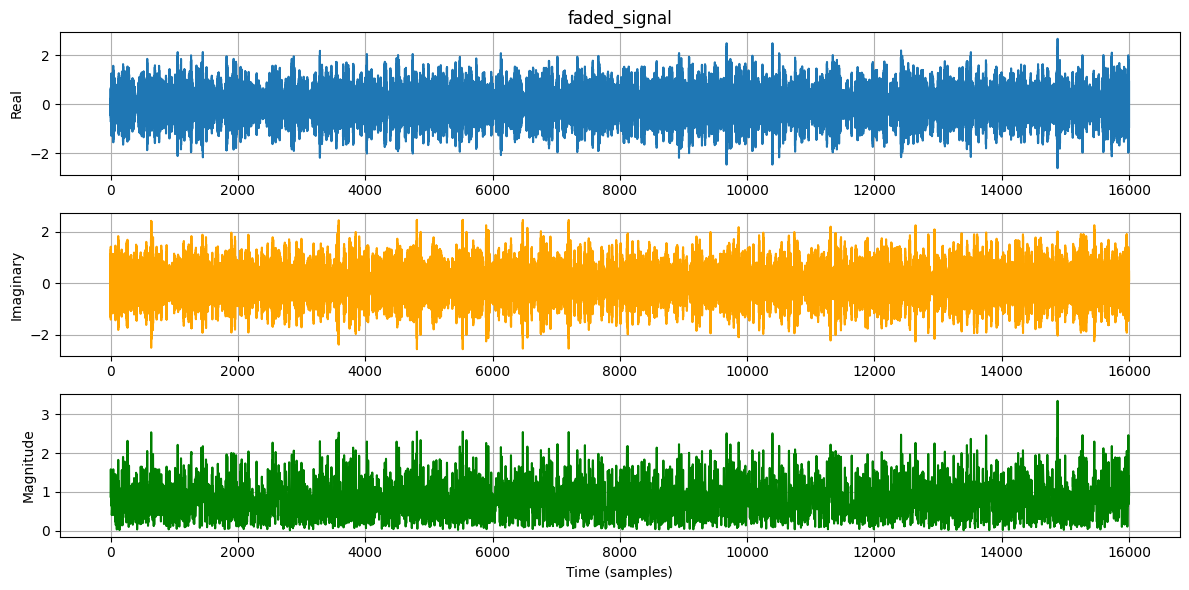

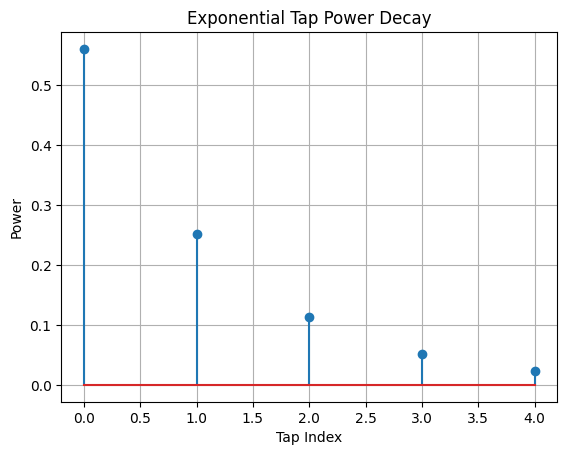

In [89]:
faded_signal = apply_multipath_fading(ofdm_signal, num_taps=5, alpha_rayleigh=0.8, snr_db=20)

### **OFDM is specifically designed to handle *frequency-selective fading*** efficiently.

In a **frequency-selective fading channel**, different frequencies (subcarriers) experience **different gains and phase shifts** due to **multipath delay spread**. This causes **intersymbol interference (ISI)** in single-carrier systems.

#### OFDM solves this by:

* **Splitting the wideband channel into many narrowband subcarriers**
* Each subcarrier is narrow enough to **experience flat fading**
* It uses a **CP** to eliminate ISI between symbols


### When is OFDM ideal?

| Fading Type                    | Is OFDM Suitable? | Reason                                        |
| ------------------------------ | ----------------- | --------------------------------------------- |
| **Flat fading**                | Yes, works      | All subcarriers see similar fading            |
| **Frequency-selective fading** | Best use case   | OFDM transforms it into many flat subchannels |


If the channel has a delay spread $T_{\text{delay}}$, and OFDM symbol duration is $T_{\text{sym}}$, we want:

$$
T_{\text{CP}} \geq T_{\text{delay}} \quad \text{and} \quad \Delta f = \frac{1}{T_{\text{sym}}} \ll \frac{1}{T_{\text{delay}}}
$$

This ensures each subcarrier sees a flat response.

### Without OFDM?

In a frequency-selective channel:

* Single-carrier systems suffer from **ISI**
* Require **complex equalizers (e.g., time-domain MMSE)**

### With OFDM?

* Subcarriers become **orthogonal flat-fading channels**
* Equalization becomes **simple per-subcarrier**
* Very efficient for 4G LTE, 5G NR, Wi-Fi, DVB, etc.



---


## Rayleigh vs. Rician — Which is Realistic?

| Fading Model | Description                                                                                | When It Occurs                                                                        |
| ------------ | ------------------------------------------------------------------------------------------ | ------------------------------------------------------------------------------------- |
| **Rayleigh** | No dominant line-of-sight (LOS) path; signal is composed entirely of multipath reflections | **Urban**, **indoor**, **NLOS** (non-line-of-sight), tunnels, deep indoor areas       |
| **Rician**   | Dominant LOS path **plus** multipath reflections                                           | **LOS scenarios**: highways, open indoor spaces, UAVs, mmWave, Wi-Fi within same room |

* **Rayleigh fading**:
  The **magnitude** of the fading envelope follows a **Rayleigh distribution** (no strong deterministic component).

* **Rician fading**:
  The fading envelope has a **dominant deterministic component** (LOS), and the rest is multipath. The **Rician K-factor** quantifies the ratio of LOS power to scattered power:

  $$
  K = \frac{\text{Power of LOS path}}{\text{Power of scattered paths}} \quad (\text{in linear or dB})
  $$

  * $K = 0 \Rightarrow$ Rayleigh fading
  * $K > 0 \Rightarrow$ Rician fading
  * $K \to \infty \Rightarrow$ AWGN channel (pure LOS)


| Environment                                | Use This Model            |
| ------------------------------------------ | ------------------------- |
| Small cell, deep indoor, urban canyon      | **Rayleigh**              |
| Open office, shopping mall with visibility | **Rician**                |
| Highway, mmWave with beamforming           | **Rician** with large $K$ |
| No multipath (e.g., fiber or ideal)        | **AWGN only**             |


### Example: 3GPP Models

* **EPA** (Extended Pedestrian A): Usually Rayleigh
* **EVA**, **ETU**: Varying degrees of Rician (especially for vehicular channels)


> **Rayleigh is more pessimistic**, but safe to simulate in **worst-case NLOS**.

> **Rician is more accurate** for modern LOS-enabled systems (e.g., 5G NR mmWave, Wi-Fi 6/7, LiFi).



---

## Rician Fading Channel Theory

Rician fading models wireless channels in environments where there is a **dominant LOS** path in addition to several scattered Non-Line-of-Sight (NLOS) components. Unlike Rayleigh fading (which assumes no LOS), Rician fading captures the combined effect of deterministic and random multipath components. 

This model is particularly relevant for:

- urban canyons
- indoor open spaces
- vehicular environments
- mmWave systems with strong beamforming

The received complex baseband signal after a multipath Rician fading channel is modeled as:

$$
y[n] = \sum_{\ell=0}^{L-1} h[\ell] \cdot x[n - \ell] + w[n]
$$

where:

* $x[n]$: Transmitted signal sample
* $h[\ell]$: Complex channel impulse response at tap $\ell$
* $w[n]$: Additive White Gaussian Noise (AWGN)
* $L$: Number of channel taps (multipath components)


### Channel Tap Structure

Each channel tap $h[\ell]$ in Rician fading consists of two components:

$$
h[\ell] = h_{\text{LOS}}[\ell] + h_{\text{NLOS}}[\ell]
$$

* $h_{\text{LOS}}[\ell]$: Deterministic LOS component (typically only for $\ell = 0$)
* $h_{\text{NLOS}}[\ell]$: Scattered component modeled as a complex Gaussian random variable

The NLOS component is assumed to follow a zero-mean complex Gaussian distribution:

$$
h_{\text{NLOS}}[\ell] \sim \mathcal{CN}\left(0, \sigma_{\ell}^2\right)
$$

The LOS component contributes only at the first tap:

$$
h_{\text{LOS}}[0] = \sqrt{P_{\text{LOS}}}, \quad h_{\text{LOS}}[\ell] = 0 \text{ for } \ell > 0
$$

### Rician K-Factor

The **Rician K-factor** quantifies the ratio of LOS power to the total NLOS power:

$$
K = \frac{P_{\text{LOS}}}{P_{\text{NLOS}}}
$$

* Expressed in dB as: $K_{\text{dB}} = 10 \log_{10}(K)$
* $K = 0$: No LOS path → Rayleigh fading
* $K \rightarrow \infty$: Dominant LOS only → AWGN channel

The total channel power is normalized as:

$$
P_{\text{total}} = P_{\text{LOS}} + P_{\text{NLOS}} = 1
$$

$$
P_{\text{LOS}} = \frac{K}{1 + K}, \quad P_{\text{NLOS}} = \frac{1}{1 + K}
$$


### Power Delay Profile

To model delay dispersion in the NLOS paths, an **exponential decay profile** is commonly used:

$$
\sigma_{\ell}^2 = \frac{e^{-\alpha \ell}}{\sum_{k=0}^{L-1} e^{-\alpha k}}
$$

* $\alpha$: Decay rate parameter (typical range: 0.3 to 1.0)
* Ensures that later taps have less power than earlier ones
* The total NLOS power across all taps is normalized to $P_{\text{NLOS}}$


| Component      | Description                              |
| -------------- | ---------------------------------------- |
| LOS component  | Deterministic power at first tap         |
| NLOS component | Rayleigh-faded, exponentially decaying   |
| K-factor       | Controls strength of LOS vs scattered    |
| Delay spread   | Modeled via exponential power profile    |
| AWGN           | Added optionally to simulate noise floor |

Rician fading provides a flexible model that bridges the gap between fully scattered Rayleigh channels and pure LOS scenarios, making it a widely used channel model in wireless system design.



In [98]:
def rician_fading(ofdm_signal, num_taps, K_dB, alpha_rayleigh, snr_db=None):
    """
    Apply Rician fading to a complex baseband signal.

    Parameters:
    - signal: Input complex baseband signal (1D array)
    - num_taps: Number of channel taps (L)
    - K_dB: Rician K-factor in dB (ratio of LOS to NLOS power)
    - alpha_rayleigh: Exponential decay rate for NLOS taps
    - snr_db: Optional SNR in dB for AWGN

    Returns:
    - faded_signal: Signal after convolution with Rician fading channel
    - h: Channel impulse response (complex-valued)
    """
    # Convert K-factor from dB to linear scale
    K_linear = 10**(K_dB / 10)

    # Compute power profile of NLOS (Rayleigh) taps
    tap_powers_nlos = np.exp(-alpha_rayleigh * np.arange(num_taps))
    tap_powers_nlos /= np.sum(tap_powers_nlos)

    # Total power is normalized to 1: divide between LOS and NLOS
    total_power = 1.0
    power_nlos = total_power / (1 + K_linear)
    power_los = total_power * K_linear / (1 + K_linear)

    # Construct NLOS Rayleigh component
    h_nlos = (np.random.randn(num_taps) + 1j * np.random.randn(num_taps)) * np.sqrt((power_nlos * tap_powers_nlos) / 2)

    # Construct LOS deterministic component (only first tap has LOS)
    h_los = np.zeros(num_taps, dtype=complex)
    h_los[0] = np.sqrt(power_los)  # deterministic LOS at delay 0

    # Combine to get final channel impulse response
    h = h_los + h_nlos

    # Convolve the signal with the Rician channel
    faded_signal = np.convolve(ofdm_signal, h, mode='full')[:len(ofdm_signal)]

    # Add AWGN if specified
    if snr_db is not None:
        signal_power = np.mean(np.abs(faded_signal)**2)
        noise_power = signal_power / (10 ** (snr_db / 10))
        noise_std = np.sqrt(noise_power / 2)
        noise = noise_std * (np.random.randn(len(faded_signal)) + 1j * np.random.randn(len(faded_signal)))
        faded_signal += noise
    
    plt.figure(figsize=(10, 3.5))
    plt.plot(np.abs(ofdm_signal), color='purple', linewidth=1)
    plt.title("Received Signal Envelope")
    plt.xlabel("Sample Index")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    taps = np.arange(len(h))
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.stem(taps, np.abs(h))
    plt.title("Magnitude of Channel Taps")
    plt.xlabel("Tap Index")
    plt.ylabel("|h[l]|")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.stem(taps, np.angle(h))
    plt.title("Phase of Channel Taps")
    plt.xlabel("Tap Index")
    plt.ylabel("∠h[l] (rad)")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return faded_signal, h


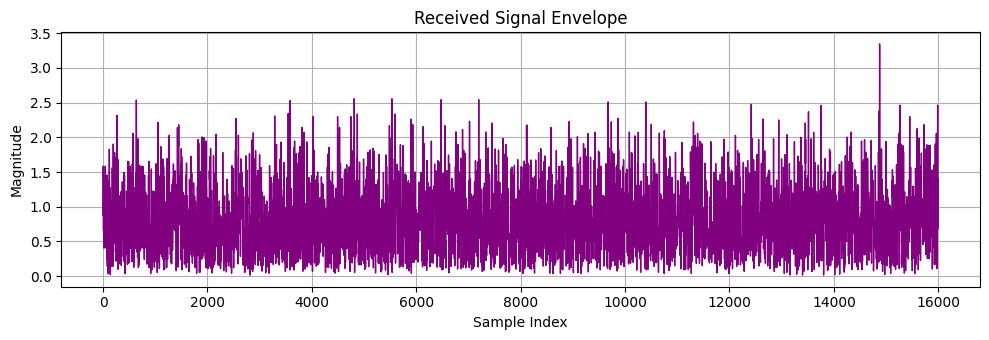

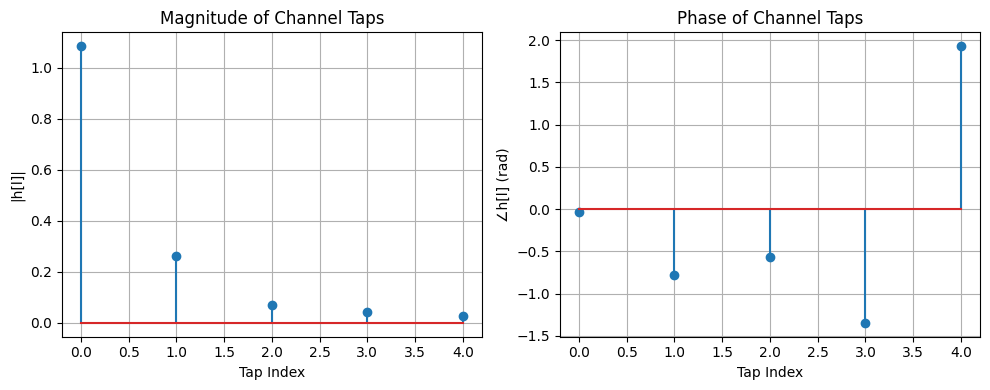

In [99]:
rician_signal, h = rician_fading(ofdm_signal, num_taps = 5, K_dB = 10, alpha_rayleigh = 0.7, snr_db = 25)


# 3GPP TR 38.901 Channel Models

The TR 38.901 3GPP document defines five main standardized channel models for G NR wireless simulations. 

Each corresponds to a deployment environment, with specific statistical characteristics for:

- LOS/NLOS probability models

- Path loss models

- Power delay profiles (PDP)

- Angular spreads and Doppler

- Cluster-based small-scale fading




| Model   | Name                    | Description                                | Frequency Range      |
| ------- | ----------------------- | ------------------------------------------ | -------------------- |
| **RMa** | **Rural Macrocell**     | Large cell, low density, open terrain      | 0.5 – 30 GHz         |
| **UMa** | **Urban Macrocell**     | Rooftop BSs serving users on streets       | 0.5 – 100 GHz        |
| **UMi** | **Urban Microcell**     | Low-height BSs in dense urban environments | 0.5 – 100 GHz        |
| **InH** | **Indoor Hotspot**      | Indoor office/open space                   | 0.5 – 100 GHz        |
| **SM**  | **Satellite to Mobile** | Optional; for satellite link simulations   | \[Separate document] |


---
---

## Time-Varying Rayleigh Multipath Channel with Doppler Spread

In mobile wireless communication, channel conditions change over time due to user movement, changes in the surrounding environment, or both. These variations introduce **Doppler spread**—a phenomenon that causes **time-selective fading** of the signal. When combined with **multipath propagation**, the result is a **time-varying frequency-selective fading channel**.

This model captures the effects of:

* **Multipath fading**: signal reflections from various physical objects.
* **Doppler effect**: time variation in the channel due to relative motion between the transmitter, receiver, or environment.

### Channel Model

The received signal $y[n]$ is modeled as:

$$
y[n] = \sum_{\ell=0}^{L-1} h[n, \ell] \cdot x[n - \ell] + w[n]
$$

where:

* $x[n]$: transmitted complex baseband signal
* $h[n, \ell]$: time-varying complex channel coefficient for tap $\ell$ at time $n$
* $L$: number of channel taps (multipath components)
* $w[n]$: additive white Gaussian noise (AWGN)


### Tap Power Profile

The power of each tap is defined by an **exponential decay profile**:

$$
\sigma^2_\ell = \frac{e^{-\alpha \ell}}{\sum_{k=0}^{L-1} e^{-\alpha k}}
$$

where:

* $\alpha$: exponential decay factor (typically in range 0.3–1.0)
* $\sigma^2_\ell$: power of the $\ell$-th tap, normalized such that $\sum_{\ell=0}^{L-1} \sigma^2_\ell = 1$

This captures the fact that earlier-arriving paths typically carry more energy than delayed reflections.


### Time Variation and Doppler Spread

Each channel tap $h[n, \ell]$ is modeled as a **zero-mean complex Gaussian random process** with a time-varying envelope that captures Doppler fading. For a mobile user with maximum Doppler frequency $f_D$, the fading variation over time follows Jakes’ Doppler spectrum.

The fading process for each tap is generated using the **sum-of-sinusoids method**, an efficient approximation of Jakes’ model. Each tap evolves over time as:

$$
h[n, \ell] = \sqrt{\sigma^2_\ell} \cdot \left( h_{\text{real}}[n, \ell] + j \cdot h_{\text{imag}}[n, \ell] \right)
$$

with:

$$
h_{\text{real}}[n, \ell] = \sqrt{\frac{2}{N}} \sum_{k=1}^{N} \cos(2\pi f_D n \cos\theta_k + \phi_k)
$$

$$
h_{\text{imag}}[n, \ell] = \sqrt{\frac{2}{N}} \sum_{k=1}^{N} \sin(2\pi f_D n \cos\theta_k + \phi_k)
$$

where:

* $N$: number of sinusoids (e.g., 16, 32, 64)
* $\theta_k$: equally spaced angles on $[0, 2\pi)$
* $\phi_k$: random initial phases uniformly distributed on $[0, 2\pi)$

This process generates a time-correlated complex Gaussian signal per tap with the desired Doppler spectrum.


### Convolution with Time-Varying Channel

The received signal is computed using a **time-varying convolution** across all taps:

$$
y[n] = \sum_{\ell=0}^{L-1} h[n, \ell] \cdot x[n - \ell]
$$

This models a channel whose impulse response varies continuously over time, introducing both frequency-selective and time-selective fading effects.


### Additive Noise

To simulate realistic reception conditions, complex Gaussian noise $w[n] \sim \mathcal{CN}(0, \sigma_w^2)$ is added after convolution. The noise power is determined based on a target Signal-to-Noise Ratio (SNR):

$$
\sigma_w^2 = \frac{P_{\text{signal}}}{10^{\text{SNR}_{\text{dB}} / 10}}
$$


| Component        | Description                                   |
| ---------------- | --------------------------------------------- |
| $L$              | Number of channel taps (multipath components) |
| $\alpha$         | Exponential decay rate for tap powers         |
| $f_D$            | Maximum Doppler frequency (Hz)                |
| $h[n, \ell]$     | Time-varying Rayleigh fading process per tap  |
| $y[n]$           | Output signal (faded + noisy)                 |
| Sum-of-sinusoids | Used to generate time-correlated fading       |
| AWGN             | Optional noise added after fading             |


In [100]:
def multipath_doppler_fading(signal, num_taps=3, alpha_rayleigh=0.7, fd=100, fs=1.0, snr_db=None, num_sinusoids=32, seed=None):
    """
    Apply time-varying Rayleigh multipath fading with Doppler spread (per tap).

    Parameters:
    - signal: Transmitted complex baseband signal (1D array)
    - num_taps: Number of multipath taps
    - alpha_rayleigh: Exponential decay rate for tap powers
    - fd: Maximum Doppler frequency (Hz)
    - fs: Sampling rate (Hz)
    - snr_db: SNR in dB for AWGN (optional)
    - num_sinusoids: Number of sinusoids for Doppler approximation
    - seed: Random seed (optional)

    Returns:
    - faded_signal: Time-varying faded signal
    - h_time: Time-varying channel impulse response matrix (shape: [len(signal), num_taps])
    """
    if seed is not None:
        np.random.seed(seed)

    N = len(signal)
    t = np.arange(N) / fs

    # Tap power profile (exponential decay)
    tap_powers = np.exp(-alpha_rayleigh * np.arange(num_taps))
    tap_powers /= np.sum(tap_powers)

    # Initialize time-varying channel matrix
    h_time = np.zeros((N, num_taps), dtype=complex)

    # Generate Doppler fading process per tap using sum-of-sinusoids
    for l in range(num_taps):
        theta = 2 * np.pi * np.arange(1, num_sinusoids + 1) / (num_sinusoids + 1)
        phi = 2 * np.pi * np.random.rand(num_sinusoids)

        real_fading = np.sqrt(2 / num_sinusoids) * np.sum(
            np.cos(2 * np.pi * fd * np.outer(t, np.cos(theta)) + phi), axis=1
        )
        imag_fading = np.sqrt(2 / num_sinusoids) * np.sum(
            np.sin(2 * np.pi * fd * np.outer(t, np.cos(theta)) + phi), axis=1
        )
        fading_process = real_fading + 1j * imag_fading
        h_time[:, l] = fading_process * np.sqrt(tap_powers[l])

    # Apply time-varying convolution
    faded_signal = np.zeros(N, dtype=complex)
    for l in range(num_taps):
        delayed_signal = np.roll(signal, l)
        delayed_signal[:l] = 0  # zero-pad causal delay
        faded_signal += h_time[:, l] * delayed_signal

    # Add AWGN if specified
    if snr_db is not None:
        signal_power = np.mean(np.abs(faded_signal)**2)
        noise_power = signal_power / (10 ** (snr_db / 10))
        noise_std = np.sqrt(noise_power / 2)
        noise = noise_std * (np.random.randn(N) + 1j * np.random.randn(N))
        faded_signal += noise
    
    plt.figure(figsize=(10, 3.5))
    plt.plot(np.abs(ofdm_signal), color='purple', linewidth=1)
    plt.title("Received Signal Envelope")
    plt.xlabel("Sample Index")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    taps = np.arange(len(h))
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.stem(taps, np.abs(h))
    plt.title("Magnitude of Channel Taps")
    plt.xlabel("Tap Index")
    plt.ylabel("|h[l]|")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.stem(taps, np.angle(h))
    plt.title("Phase of Channel Taps")
    plt.xlabel("Tap Index")
    plt.ylabel("∠h[l] (rad)")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    for l in range(h_time.shape[1]):
        plt.plot(np.abs(h_time[:, l]), label=f'Tap {l}')
    plt.title("Time-Varying Magnitude of Channel Taps")
    plt.xlabel("Time Index")
    plt.ylabel("|h(t,l)|")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return faded_signal, h_time


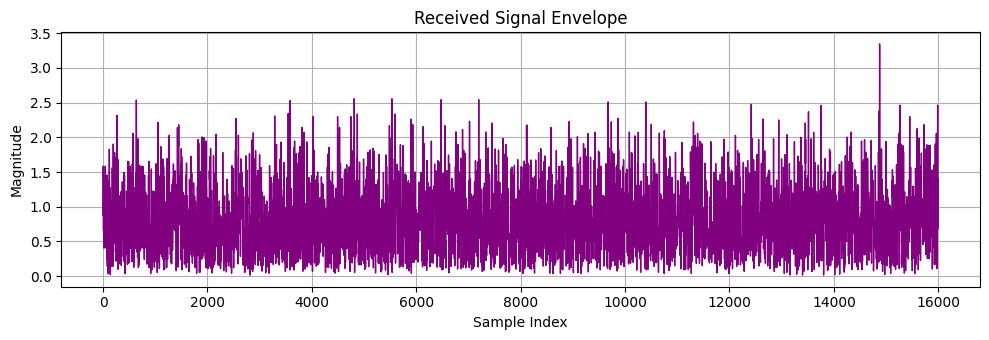

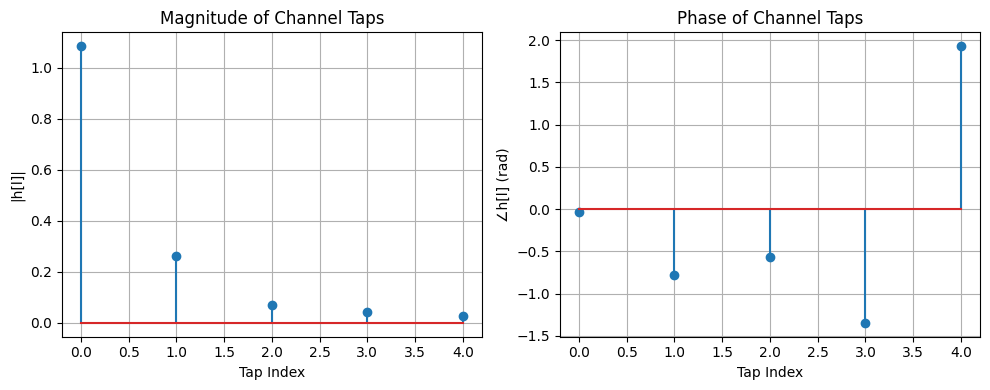

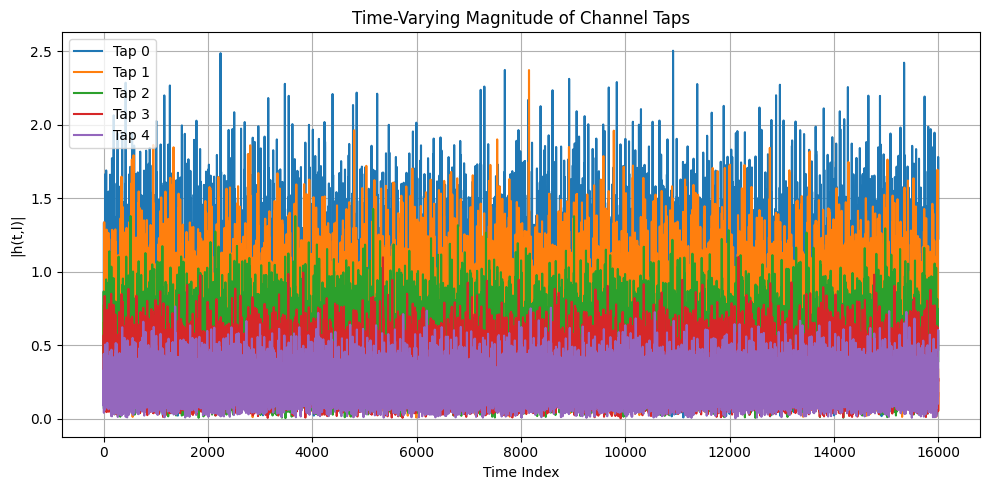

In [ ]:
faded_signal, h_time = multipath_doppler_fading(ofdm_signal, num_taps=5, alpha_rayleigh=0.6, fd=150, fs=1e3, snr_db=20)


## Frequency Offset and Phase Noise in Wireless Communication


In practical wireless communication systems, **ideal oscillators** are assumed during modulation and demodulation. However, in reality, local oscillators (LOs) in the transmitter and receiver are never perfectly synchronized. They introduce imperfections such as:

* **Carrier frequency offset** (CFO): due to oscillator frequency mismatch

* **Phase noise**: due to rapid phase variations (jitter), often modeled as a random process

These effects degrade system performance, especially in systems like **OFDM**, where they destroy subcarrier orthogonality.


## 1. Carrier Frequency Offset (CFO)

Carrier frequency offset occurs when the transmitter and receiver oscillators differ by a small frequency:

$$
f_{\text{offset}} = f_{\text{LO,rx}} - f_{\text{LO,tx}}
$$

### Effect on Baseband Signal

Let $s[n]$ be the transmitted baseband signal. The received signal with frequency offset is:

$$
r[n] = s[n] \cdot e^{j 2\pi \Delta f n T_s}
$$

where:

* $\Delta f = f_{\text{offset}}$: frequency offset in Hz
* $T_s$: sampling interval ( $T_s = 1/f_s$ )
* $n$: sample index

This offset introduces a **linear phase rotation** over time, which:

* Causes constellation rotation in single-carrier systems
* Destroys subcarrier orthogonality in OFDM, leading to **inter-carrier interference (ICI)**

### Normalized Frequency Offset (ε)

For OFDM systems with subcarrier spacing $\Delta f_{\text{sub}}$, the normalized frequency offset is defined as:

$$
\epsilon = \frac{\Delta f}{\Delta f_{\text{sub}}}
$$

Even small $\epsilon$ values cause significant BER degradation.


## 2. Phase Noise

Phase noise is a **rapid, random fluctuation** in the phase of the carrier signal, typically modeled as a **stochastic process**. It originates from short-term instability in oscillator frequency due to electronic noise and jitter.

### Baseband Effect

Let $\phi[n]$ be a random phase process (e.g., a Wiener process). The received signal becomes:

$$
r[n] = s[n] \cdot e^{j \phi[n]}
$$

This introduces **non-linear, time-varying phase distortion**, even if the carrier frequency is aligned.

### Phase Noise Modeling

Common models for $\phi[n]$:

* **Wiener process**: $\phi[n] = \phi[n-1] + \Delta\phi[n]$, where $\Delta\phi[n] \sim \mathcal{N}(0, \sigma_\phi^2)$
* **Filtered white noise**: simulating phase-locked loop behavior

Phase noise affects:

* **QAM constellation stability**
* **Subcarrier leakage** in OFDM (similar to ICI)
* **Coherent demodulation** in MIMO and tracking loops


## 3. Combined Model

In many practical models, both effects are applied simultaneously:

$$
r[n] = s[n] \cdot e^{j(2\pi \Delta f n T_s + \phi[n])}
$$

This models a system with:

* **Carrier offset** (deterministic phase rotation)
* **Phase noise** (random walk or bounded phase jitter)


## 4. Impact on Systems

| System Type    | Impact of Frequency Offset | Impact of Phase Noise |
| -------------- | -------------------------- | --------------------- |
| OFDM           | Inter-carrier interference | Phase rotation, ICI   |
| Single-carrier | Constellation rotation     | Tracking loss, jitter |
| Coherent MIMO  | Channel estimation error   | Synchronization loss  |





| Term             | Description                                            |
| ---------------- | ------------------------------------------------------ |
| Frequency Offset | Mismatch between TX and RX oscillator frequencies      |
| Phase Noise      | Random phase fluctuation due to jitter/noise           |
| Modeling         | Apply complex exponential phase distortion to signal   |
| Common Models    | Linear phase drift (CFO), random walk (Wiener process) |
| Critical for     | OFDM, MIMO, coherent receivers, radar systems          |



In [104]:
def apply_full_channel_model(
    signal,
    fs=1.0,
    num_taps=3,
    alpha_rayleigh=0.7,
    fd=100,
    snr_db=None,
    num_sinusoids=32,
    freq_offset_hz=0.0,
    phase_noise_std=0.0,
    seed=None
):
    """
    Apply multipath Rayleigh fading with Doppler, frequency offset, and phase noise.

    Parameters:
    - signal: Input complex baseband signal (1D array)
    - fs: Sampling rate in Hz
    - num_taps: Number of Rayleigh taps
    - alpha_rayleigh: Exponential decay rate for power profile
    - fd: Max Doppler frequency in Hz
    - snr_db: SNR in dB for AWGN (optional)
    - num_sinusoids: Number of sinusoids for Doppler fading
    - freq_offset_hz: Carrier frequency offset (Hz)
    - phase_noise_std: Std dev of phase noise increments (radians)
    - seed: Optional seed for reproducibility

    Returns:
    - impaired_signal: Output signal with all impairments
    - h_time: Time-varying channel taps [len(signal), num_taps]
    """

    if seed is not None:
        np.random.seed(seed)

    N = len(signal)
    t = np.arange(N) / fs

    # Exponential power delay profile
    tap_powers = np.exp(-alpha_rayleigh * np.arange(num_taps))
    tap_powers /= np.sum(tap_powers)

    # Generate time-varying Rayleigh fading per tap
    h_time = np.zeros((N, num_taps), dtype=complex)
    for l in range(num_taps):
        theta = 2 * np.pi * np.arange(1, num_sinusoids + 1) / (num_sinusoids + 1)
        phi = 2 * np.pi * np.random.rand(num_sinusoids)
        real = np.sqrt(2 / num_sinusoids) * np.sum(
            np.cos(2 * np.pi * fd * np.outer(t, np.cos(theta)) + phi), axis=1)
        imag = np.sqrt(2 / num_sinusoids) * np.sum(
            np.sin(2 * np.pi * fd * np.outer(t, np.cos(theta)) + phi), axis=1)
        fading_process = real + 1j * imag
        h_time[:, l] = fading_process * np.sqrt(tap_powers[l])

    # Time-varying convolution
    faded_signal = np.zeros(N, dtype=complex)
    for l in range(num_taps):
        delayed = np.roll(signal, l)
        delayed[:l] = 0
        faded_signal += h_time[:, l] * delayed

    # Apply frequency offset: r[n] *= exp(j*2pi*f*nTs)
    freq_rot = np.exp(1j * 2 * np.pi * freq_offset_hz * t)
    faded_signal *= freq_rot

    # Apply phase noise as random walk
    if phase_noise_std > 0.0:
        delta_phi = np.random.normal(0, phase_noise_std, size=N)
        phi = np.cumsum(delta_phi)
        faded_signal *= np.exp(1j * phi)

    # Add AWGN
    if snr_db is not None:
        sig_power = np.mean(np.abs(faded_signal) ** 2)
        noise_power = sig_power / (10 ** (snr_db / 10))
        noise = (np.random.randn(N) + 1j * np.random.randn(N)) * np.sqrt(noise_power / 2)
        faded_signal += noise
    
    plt.figure(figsize=(10, 5))
    for l in range(h_time.shape[1]):
        plt.plot(np.abs(h_time[:, l]), label=f'Tap {l}')
    plt.title("Time-Varying Channel Tap Magnitudes")
    plt.xlabel("Sample Index")
    plt.ylabel("|h[n, l]|")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return faded_signal, h_time


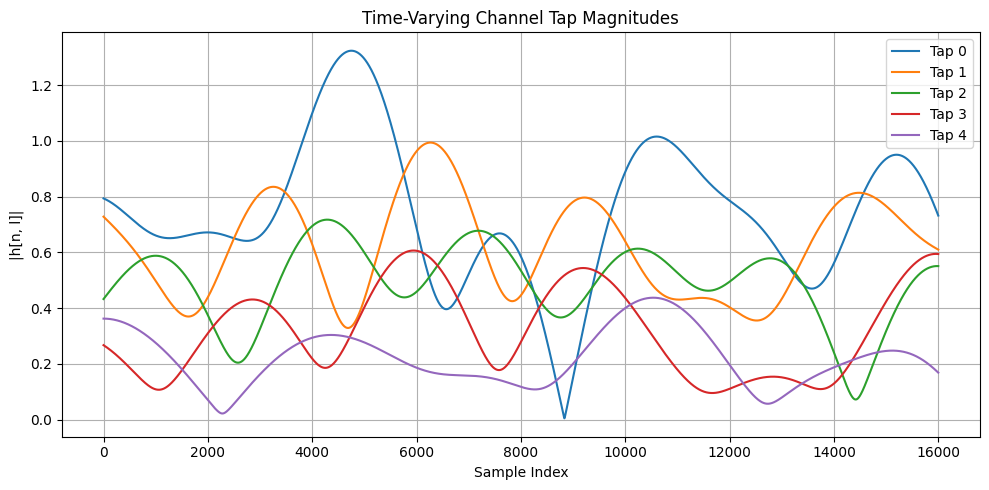

In [105]:
faded_signal, h_time = apply_full_channel_model(
    signal=ofdm_signal,
    fs=1e6,                     # 1 MHz sampling rate
    num_taps=5,
    alpha_rayleigh=0.6,
    fd=200,                     # 200 Hz Doppler
    snr_db=20,
    freq_offset_hz=100,         # 100 Hz carrier offset
    phase_noise_std=1e-3,       # radians per sample
    seed=42
)


## Timing Offset and Jitter in Communication Systems

In practical digital communication systems, accurate **symbol timing** is essential for correct demodulation and decoding of the received signal. However, real-world impairments such as **timing offset** and **jitter** arise due to imperfections in oscillators and sampling circuits. These effects distort the received waveform, increase inter-symbol interference (ISI), and degrade the system's bit error rate (BER).


## 1. Timing Offset

**Timing offset** occurs when the receiver samples the incoming signal at an incorrect time relative to the symbol boundaries.

### Causes:

* Mismatch between transmitter and receiver clock frequencies
* Propagation delay not accurately accounted for
* Lack of synchronization during receiver acquisition

### Effect on Received Signal

Assume ideal transmitted signal $x(t)$ is sampled at symbol period $T_s$. If the receiver samples at $t = nT_s + \tau$, where $\tau$ is a fixed offset, then the received samples become:

$$
r[n] = x(nT_s + \tau)
$$

This leads to:

* **Suboptimal symbol detection**
* Increased **inter-symbol interference (ISI)**, especially with pulse-shaped signals (e.g., raised cosine)

In multicarrier systems like OFDM, timing offset leads to:

* **Loss of orthogonality** between subcarriers
* Inter-symbol and inter-carrier interference
* Phase rotations across subcarriers (if offset is within the cyclic prefix)

### Types

* **Integer timing offset**: Offset by full symbols (can be corrected using frame synchronization)
* **Fractional timing offset**: Offset by a fraction of symbol period (requires interpolation or matched filtering)


## 2. Timing Jitter

### Definition

**Timing jitter** refers to **random, time-varying fluctuations** in the timing of sampling instants. Instead of sampling exactly at $t = nT_s$, the receiver samples at:

$$
t_n = nT_s + \delta_n
$$

where $\delta_n$ is a random variable representing instantaneous timing error (jitter) at time index $n$.

### Causes

* Thermal noise in clock circuits
* Power supply noise affecting oscillators
* Phase noise in phase-locked loops (PLLs)
* Quantization and jitter in ADC clock sources

### Effect on Signal

Timing jitter causes:

* **Non-uniform sampling** of the waveform
* Distortion of signal amplitude (even if the carrier is intact)
* Degradation of **eye diagram** and **symbol integrity**
* Increased **bit error rate**, especially in high-speed and high-order modulation systems

## 3. Modeling Timing Offset and Jitter

### 3.1 Timing Offset

For a baseband signal sampled at incorrect time offset $\tau$:

$$
r[n] = x(nT_s + \tau)
$$

In discrete simulations, this is implemented by:

* Interpolation (e.g., sinc or linear) to resample at $\tau$
* Circular shift for integer sample offsets (in discrete time)


### 3.2 Timing Jitter

Timing jitter is modeled as:

$$
t_n = nT_s + \delta_n, \quad \delta_n \sim \mathcal{N}(0, \sigma_t^2)
$$

where:

* $\sigma_t$: standard deviation of timing noise
* $\delta_n$: independent or correlated noise samples (white or colored jitter)

Interpolation is used to obtain $r[n] = x(t_n)$ from the original waveform.


## 4. Impact on Communication Systems

| System                  | Impact of Timing Offset  | Impact of Jitter                            |
| ----------------------- | ------------------------ | ------------------------------------------- |
| Single-carrier          | ISI, degraded sampling   | Symbol distortion                           |
| OFDM                    | ICI, symbol misalignment | Loss of orthogonality, amplitude distortion |
| High-speed serial links | Eye closure              | Jitter-induced sampling errors              |
| MIMO                    | Synchronization mismatch | Channel estimation errors                   |

---




In [110]:
from scipy.interpolate import interp1d


def apply_timing_offset_and_jitter(signal, timing_offset=0.0, jitter_std=0.0, fs=1.0, seed=None):
    """
    Apply constant timing offset and random timing jitter to a signal.

    Parameters:
    - signal: Input complex baseband signal
    - timing_offset: Constant delay in seconds (e.g., 0.25 * Ts)
    - jitter_std: Std dev of jitter (in seconds)
    - fs: Sampling frequency (Hz)
    - seed: Random seed for reproducibility

    Returns:
    - distorted_signal: Resampled signal with timing offset and jitter
    - sampling_instants: Actual sampling times applied
    """
    if seed is not None:
        np.random.seed(seed)

    N = len(signal)
    t_original = np.arange(N) / fs
    Ts = 1 / fs

    # Timing offset + jitter
    jitter = np.random.normal(0, jitter_std, size=N)
    sampling_instants = t_original + timing_offset + jitter

    # Interpolation
    interp_real = interp1d(t_original, signal.real, kind='linear', bounds_error=False, fill_value="extrapolate")
    interp_imag = interp1d(t_original, signal.imag, kind='linear', bounds_error=False, fill_value="extrapolate")
    distorted_real = interp_real(sampling_instants)
    distorted_imag = interp_imag(sampling_instants)
    distorted_signal = distorted_real + 1j * distorted_imag

    return distorted_signal, sampling_instants


In [111]:
def plot_eye_diagram(signal, sps=1, span=2, offset=0):
    """
    Plot an eye diagram for the given complex signal (real part only).

    Parameters:
    - signal: Input signal
    - sps: Samples per symbol
    - span: How many symbol periods per trace
    - offset: Optional sample offset
    """
    trace_len = span * sps
    num_traces = (len(signal) - offset) // trace_len

    plt.figure(figsize=(10, 4))
    for i in range(num_traces):
        start = offset + i * trace_len
        end = start + trace_len
        trace = signal[start:end]
        if len(trace) == trace_len:
            plt.plot(np.arange(trace_len), np.real(trace), color='blue', alpha=0.3)
    plt.title("Eye Diagram (Real Part)")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


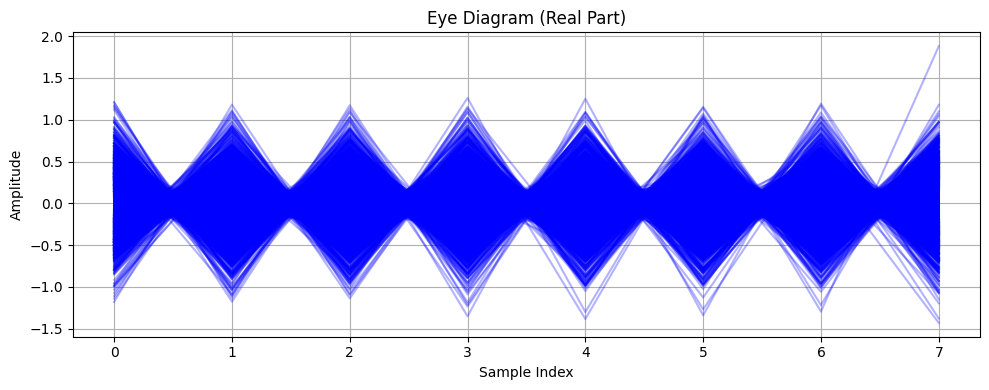

In [112]:
fs = 1e6
Ts = 1 / fs
timing_offset = 0.25 * Ts
jitter_std = 0.03 * Ts
distorted_signal, _ = apply_timing_offset_and_jitter(ofdm_signal, timing_offset, jitter_std, fs=fs, seed=42)
plot_eye_diagram(distorted_signal, sps=4)


## Timing Synchronization in OFDM Systems

In practical OFDM systems, the receiver must determine **when to start FFT demodulation**, i.e., the **symbol timing**. Incorrect timing leads to:

* Loss of orthogonality
* Inter-symbol interference (ISI)
* Inter-carrier interference (ICI)

**Timing synchronization** is the process of identifying the correct start of the OFDM symbol. Two popular techniques are:

1. **Cyclic Prefix (CP) Autocorrelation**
2. **Schmidl-Cox Algorithm**


## 1. Cyclic Prefix (CP) Autocorrelation

In OFDM, each symbol is extended with a **cyclic prefix** (CP), which is a copy of the last $L_{\text{CP}}$ samples of the IFFT output. The receiver can exploit this redundancy to find symbol boundaries.

Let the received signal be $r[n]$, and the expected symbol length be $L = N + L_{\text{CP}}$, where:

* $N$: IFFT size (data part)
* $L_{\text{CP}}$: CP length

Define the following correlation metric at lag $d$:

$$
R[d] = \sum_{n=0}^{L_{\text{CP}}-1} r^*[d+n] \cdot r[d+n+N]
$$

$$
P[d] = \left| R[d] \right|
$$

$$
E[d] = \sum_{n=0}^{L_{\text{CP}}-1} \left( |r[d+n]|^2 + |r[d+n+N]|^2 \right)
$$

Then define the **timing metric**:

$$
M[d] = \frac{P[d]^2}{E[d]^2}
$$

* $M[d]$ peaks at the start of the OFDM symbol, where the CP and the end of the symbol match perfectly.
* This method is computationally efficient and works well for moderate SNRs and slow fading.

--- 

## 2. Schmidl-Cox Algorithm


Schmidl and Cox proposed a robust method using a **training symbol** with **two identical halves** in the time domain. The receiver correlates these halves to detect timing.

### Transmitted Training Symbol

Let the training symbol $x[n]$ be structured as:

$$
x = [a, a]
$$

where $a$ is a sequence of $N/2$ samples.

At the receiver, the signal is:

$$
r[n] = x[n - d] + w[n]
$$

### Timing Metric

Let $D$ be the distance between the repeated halves (e.g., $D = N/2$). Then define:

$$
P[d] = \sum_{n=0}^{D-1} r^*[n+d] \cdot r[n+d+D]
$$

$$
R[d] = \sum_{n=0}^{D-1} |r[n+d+D]|^2
$$

$$
M[d] = \frac{|P[d]|^2}{(R[d])^2}
$$

### Interpretation

* $M[d]$ produces a **plateau** followed by a **sharp drop**, marking the end of the training symbol.
* The **start of the plateau** corresponds to the correct FFT window.
* Robust to frequency offset and noise, which makes it suitable for wireless OFDM (e.g., IEEE 802.11a/g/n).

---

Timing synchronization is a critical first step in OFDM reception. Both CP autocorrelation and the Schmidl-Cox method estimate the correct FFT window by exploiting structure in the time-domain waveform. In practice, **coarse timing** is often done using Schmidl-Cox, followed by **fine timing** using channel estimation or pilot symbols.



In [113]:
def timing_sync_cp_autocorr(rx_signal, N, cp_len):
    """
    Estimate symbol start using cyclic prefix autocorrelation.

    Parameters:
    - rx_signal: Received signal (1D complex numpy array)
    - N: FFT size (data part length)
    - cp_len: Cyclic prefix length

    Returns:
    - timing_index: Estimated start index of OFDM symbol
    - metric: Correlation metric (1D array)
    """
    metric = []
    for d in range(len(rx_signal) - N - cp_len):
        r1 = rx_signal[d : d + cp_len]
        r2 = rx_signal[d + N : d + N + cp_len]
        R = np.sum(np.conj(r1) * r2)
        E = np.sum(np.abs(r1)**2 + np.abs(r2)**2)
        m = np.abs(R)**2 / (E**2 + 1e-12)  # avoid divide by zero
        metric.append(m)

    timing_index = np.argmax(metric)
    return timing_index, np.array(metric)


In [114]:
def timing_sync_schmidl_cox(rx_signal, D):
    """
    Estimate timing using Schmidl-Cox algorithm.

    Parameters:
    - rx_signal: Received signal (1D complex numpy array)
    - D: Length of repeated half (typically FFT size // 2)

    Returns:
    - timing_index: Estimated start index of OFDM training symbol
    - metric: Timing metric M[d] array
    """
    metric = []
    for d in range(len(rx_signal) - 2*D):
        P = np.sum(np.conj(rx_signal[d:d+D]) * rx_signal[d+D:d+2*D])
        R = np.sum(np.abs(rx_signal[d+D:d+2*D])**2)
        m = np.abs(P)**2 / (R**2 + 1e-12)
        metric.append(m)

    timing_index = np.argmax(metric)
    return timing_index, np.array(metric)


In [115]:
# Assume rx_signal is your received waveform (numpy array)
N = 64
cp_len = 16
D = N // 2  # For Schmidl-Cox

# CP-based
idx_cp, cp_metric = timing_sync_cp_autocorr(rx_signal, N, cp_len)

# Schmidl-Cox
idx_sc, sc_metric = timing_sync_schmidl_cox(rx_signal, D)


In [116]:
def plot_timing_metric(metric, title="Timing Metric"):
    plt.figure(figsize=(10, 4))
    plt.plot(metric)
    plt.title(title)
    plt.xlabel("Sample Index")
    plt.ylabel("Metric Value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



---

## Frequency Offset Correction and Frame Detection in Digital Communication

### 1. Frequency Offset Correction

#### Overview

In practical systems, mismatch between transmitter and receiver oscillator frequencies introduces a **carrier frequency offset (CFO)**. This causes a **time-varying phase rotation** in the received signal, which severely degrades performance in systems like OFDM by introducing:

* **Inter-carrier interference (ICI)**
* **Symbol rotation and spreading**

#### Mathematical Model

Let $x[n]$ be the transmitted baseband signal. The received signal $r[n]$ with frequency offset $\Delta f$ becomes:

$$
r[n] = x[n] \cdot e^{j 2\pi \Delta f n T_s} + w[n]
$$

where:

* $\Delta f$: Frequency offset (Hz)
* $T_s$: Sampling period
* $w[n]$: Additive noise

This introduces a **linear phase drift** over time.

---

### Frequency Offset Estimation (Coarse)

If a signal contains **two identical segments** (like in the Schmidl-Cox preamble), the phase difference between them can be used to estimate the CFO:

$$
\phi = \angle \left( \sum_{n=0}^{N-1} r[n] \cdot r^*[n+N] \right)
$$

$$
\Delta f = \frac{\phi}{2\pi N T_s}
$$

This works because the frequency offset causes the second half to rotate by an additional phase:

$$
e^{j 2\pi \Delta f N T_s}
$$

---

### Frequency Offset Correction

Once $\Delta f$ is estimated, the correction is applied by rotating the received signal with the opposite phase:

$$
r_{\text{corr}}[n] = r[n] \cdot e^{-j 2\pi \Delta f n T_s}
$$

This effectively compensates for the CFO and restores the signal's phase coherence.

---

## Frame Detection Using Preambles

**Frame detection** identifies the start of a packet or OFDM frame. This is usually done using a known **preamble sequence** inserted at the beginning of each frame.

Popular sequences:

* **Zadoff-Chu (ZC)**: Used in LTE/5G for synchronization
* **PN (Pseudorandom Noise) sequences**: Used in Wi-Fi and spread-spectrum systems

### Matched Filtering for Detection

Let $p[n]$ be the known preamble (length $L$), and $r[n]$ the received signal. The **cross-correlation** or **matched filter** output is:

$$
y[n] = \sum_{k=0}^{L-1} r[n + k] \cdot p^*[k]
$$

The frame start is where $|y[n]|$ reaches a peak:

$$
\text{frame\_start} = \arg\max_n |y[n]|
$$

This works because convolution with the conjugate of the known sequence $p^*[k]$ maximizes the output when alignment occurs.

---

### Zadoff-Chu Sequences

Zadoff-Chu (ZC) sequences are a family of **constant amplitude** and **zero autocorrelation** sequences. A ZC sequence of length $N$ is defined as:

$$
x[n] = e^{-j \frac{\pi q n (n+1)}{N}}, \quad n = 0, 1, \dots, N-1
$$

where:

* $N$: sequence length (odd number)
* $q$: root index (coprime to $N$)

**Properties**:

* Constant magnitude
* Ideal autocorrelation:

  $$
  \sum_n x[n] x^*[n + \tau] = 0 \quad \text{for } \tau \ne 0
  $$
* Used in 3GPP LTE/5G for timing, synchronization, and random access

---

### PN Sequences (e.g., m-sequences)

PN sequences are generated using shift registers and have excellent **autocorrelation properties**:

$$
R_p[\tau] =
\begin{cases}
1, & \text{if } \tau = 0 \\
-1/N, & \text{if } \tau \ne 0
\end{cases}
$$

They are commonly used in:

* DSSS/CDMA systems
* Wi-Fi synchronization fields (e.g., Short Training Field)

---


| Function                    | Description                                            |
| --------------------------- | ------------------------------------------------------ |
| Frequency offset estimation | Use phase difference between repeated signal parts     |
| Frequency correction        | Rotate received signal by $e^{-j 2\pi \Delta f n T_s}$ |
| Frame detection             | Cross-correlate received signal with known preamble    |
| Preamble types              | Zadoff-Chu (5G), PN/m-sequences (Wi-Fi/CDMA)           |




In [117]:
def estimate_frequency_offset(rx_signal, N, fs):
    """
    Estimate frequency offset using two repeated OFDM halves.

    Parameters:
    - rx_signal: Received signal (must include two identical halves)
    - N: Length of one half (e.g., FFT size / 2)
    - fs: Sampling frequency in Hz

    Returns:
    - freq_offset: Estimated frequency offset in Hz
    """
    P = np.sum(rx_signal[:N] * np.conj(rx_signal[N:2*N]))
    phase_diff = np.angle(P)
    freq_offset = phase_diff / (2 * np.pi * N / fs)
    return freq_offset


In [118]:
def correct_frequency_offset(rx_signal, freq_offset, fs):
    """
    Apply frequency offset correction.

    Parameters:
    - rx_signal: Received signal
    - freq_offset: Estimated offset in Hz
    - fs: Sampling frequency in Hz

    Returns:
    - corrected_signal: Frequency-compensated signal
    """
    N = len(rx_signal)
    t = np.arange(N) / fs
    correction = np.exp(-1j * 2 * np.pi * freq_offset * t)
    return rx_signal * correction


In [121]:
def detect_frame_start(rx_signal, preamble):
    """
    Detect frame start using matched filter (cross-correlation).

    Parameters:
    - rx_signal: Received complex signal
    - preamble: Known preamble (1D array)

    Returns:
    - start_index: Estimated frame start index
    - correlation: Cross-correlation result (magnitude)
    """
    correlation = np.abs(np.correlate(rx_signal, preamble[::-1].conj(), mode='valid'))
    start_index = np.argmax(correlation)
    return start_index, correlation


In [119]:
def generate_zadoff_chu_seq(N, q):
    """
    Generate a Zadoff-Chu sequence.

    Parameters:
    - N: Sequence length (must be prime or co-prime to q)
    - q: Root index (must be coprime to N)

    Returns:
    - zc_seq: Complex Zadoff-Chu sequence of length N
    """
    n = np.arange(N)
    zc_seq = np.exp(-1j * np.pi * q * n * (n + 1) / N)
    return zc_seq


In [122]:
fs = 1e6        # 1 MHz sampling rate
N = 64          # FFT size or repeated segment length

# --- Frequency Offset ---
freq_offset_est = estimate_frequency_offset(rx_signal, N//2, fs)
rx_corrected = correct_frequency_offset(rx_signal, freq_offset_est, fs)

# --- Zadoff-Chu Preamble ---
zc = generate_zadoff_chu_seq(N=63, q=5)

# --- Frame Detection ---
start_idx, corr = detect_frame_start(rx_corrected, zc)


## Channel Equalization: LS and MMSE Methods

In digital communication systems, especially in OFDM and MIMO, the signal received over a wireless channel undergoes distortion due to multipath fading. To recover the original transmitted signal, **equalization** is applied to **undo the channel effect**.

The system model is:

$$
y = Hx + n
$$

where:

* $y$: Received signal vector
* $H$: Channel matrix or frequency-domain channel coefficient
* $x$: Transmitted signal vector (unknown)
* $n$: Additive noise vector (e.g., AWGN)

The goal of equalization is to estimate $x$ from $y$ using knowledge (or estimation) of $H$.

## 1. Least Squares (LS) Equalization

Minimize the **squared error** between the observed signal and the predicted signal:

$$
\hat{x}_{\text{LS}} = \arg\min_x \| y - Hx \|^2
$$

The LS solution is obtained by solving the normal equations:

$$
\hat{x}_{\text{LS}} = (H^H H)^{-1} H^H y
$$

* $H^H$: Hermitian (conjugate transpose) of $H$
* If $H$ is diagonal (e.g., in OFDM), this simplifies to:

  $$
  \hat{x}_{\text{LS}}[k] = \frac{y[k]}{H[k]} \quad \text{(element-wise division)}
  $$

**Assumptions**:

* Channel is known
* Noise is **ignored** (or treated as unknown interference)
* LS does **not account for noise statistics**

---

## 2. Minimum Mean Squared Error (MMSE) Equalization

Minimize the **mean squared error (MSE)** between the true symbol and the estimated symbol, **taking noise into account**:

$$
\hat{x}_{\text{MMSE}} = \arg\min_{\hat{x}} \mathbb{E}\left[ \| x - \hat{x} \|^2 \right]
$$

This is a **Bayesian estimator** assuming known statistics for signal and noise.

The MMSE equalizer is given by:

$$
\hat{x}_{\text{MMSE}} = \left( H^H H + \sigma_n^2 I \right)^{-1} H^H y
$$

* $\sigma_n^2$: Noise variance
* $I$: Identity matrix

For scalar channels (e.g., OFDM subcarriers with independent flat-fading):

$$
\hat{x}_{\text{MMSE}}[k] = \frac{H^*[k]}{|H[k]|^2 + \sigma_n^2} \cdot y[k]
$$

or equivalently:

$$
\hat{x}_{\text{MMSE}}[k] = \frac{y[k]}{H[k] + \sigma_n^2 / H^*[k]}
$$

* MMSE reduces to LS when $\sigma_n^2 \to 0$
* MMSE prevents noise amplification when $H[k]$ is small



## Comparison: LS vs MMSE

| Method | Formula                             | Accounts for Noise? | Inverse Involves      | Stability                          |
| ------ | ----------------------------------- | ------------------- | --------------------- | ---------------------------------- |
| LS     | $(H^H H)^{-1} H^H y$                | No                  | Channel matrix only   | May amplify noise if $H \approx 0$ |
| MMSE   | $(H^H H + \sigma_n^2 I)^{-1} H^H y$ | Yes                 | Channel + noise power | More robust at low SNR             |

---

## Use Cases

* **LS**: Fast and simple, used when SNR is high or noise is negligible
* **MMSE**: Used in practical systems where noise matters (e.g., LTE/5G receivers)




MSE (LS): 0.0441
MSE (MMSE): 0.0384


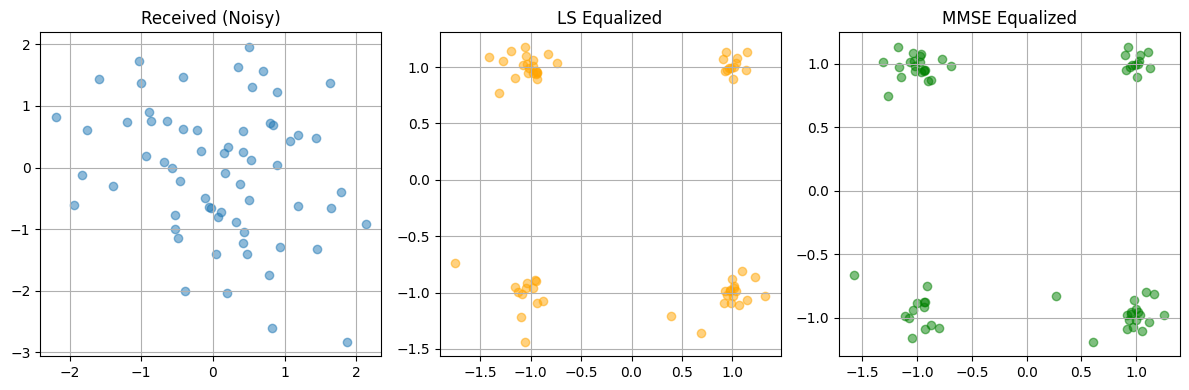

In [126]:
def ls_equalizer(H_est, Y):
    """
    LS Equalizer: X_hat = Y / H_est
    """
    H_est_safe = np.where(H_est == 0, 1e-12, H_est)
    return Y / H_est_safe

def mmse_equalizer(H_est, Y, noise_var):
    """
    MMSE Equalizer: X_hat = (H* / (|H|^2 + N0)) * Y
    """
    H_abs2 = np.abs(H_est) ** 2
    denom = H_abs2 + noise_var
    denom = np.where(denom == 0, 1e-12, denom)
    return (np.conj(H_est) / denom) * Y

# ---------------- Simulation ----------------
def simulate_equalization(N=64, noise_var=0.01):
    # Generate random QPSK symbols
    tx_symbols = np.random.choice([-1, 1], size=N) + 1j * np.random.choice([-1, 1], size=N)

    # Generate Rayleigh channel
    H = (np.random.randn(N) + 1j * np.random.randn(N)) / np.sqrt(2)

    # Apply channel and AWGN
    noise = np.sqrt(noise_var/2) * (np.random.randn(N) + 1j * np.random.randn(N))
    rx_symbols = H * tx_symbols + noise

    # Equalize
    X_ls = ls_equalizer(H, rx_symbols)
    X_mmse = mmse_equalizer(H, rx_symbols, noise_var)

    # Compute errors
    mse_ls = np.mean(np.abs(X_ls - tx_symbols)**2)
    mse_mmse = np.mean(np.abs(X_mmse - tx_symbols)**2)

    print(f"MSE (LS): {mse_ls:.4f}")
    print(f"MSE (MMSE): {mse_mmse:.4f}")

    # Plot constellation comparison
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.scatter(rx_symbols.real, rx_symbols.imag, alpha=0.5)
    plt.title("Received (Noisy)")
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.scatter(X_ls.real, X_ls.imag, alpha=0.5, color='orange')
    plt.title("LS Equalized")
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.scatter(X_mmse.real, X_mmse.imag, alpha=0.5, color='green')
    plt.title("MMSE Equalized")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Run it
simulate_equalization()


---
## Error Vector Magnitude (EVM)

**Error Vector Magnitude (EVM)** is a key metric used in digital communications to **quantify the quality of a modulated signal**. It compares the **received symbol** to the **ideal (reference) symbol**, capturing all imperfections including:

* Noise
* Phase noise
* Frequency offset
* IQ imbalance
* Nonlinearities

EVM is widely used in standards such as **3GPP LTE**, **5G NR**, **Wi-Fi**, and **IEEE 802.16** for receiver and transmitter performance evaluation.

### System Model

Let:

* $x_n$: Ideal transmitted symbol (reference constellation point)
* $\hat{x}_n$: Received symbol after demodulation and equalization

Then the **error vector** is defined as:

$$
e_n = \hat{x}_n - x_n
$$

The **EVM** is the **root mean square (RMS)** of the magnitude of these error vectors, normalized by the reference symbol energy.

**Linear EVM (unitless):**

$$
\text{EVM}_{\text{rms}} = \sqrt{ \frac{ \sum_{n=1}^N | \hat{x}_n - x_n |^2 }{ \sum_{n=1}^N |x_n|^2 } }
$$

**EVM in percentage:**

$$
\text{EVM}_{\%} = \text{EVM}_{\text{rms}} \times 100
$$

**EVM in dB:**

$$
\text{EVM}_{\text{dB}} = 20 \cdot \log_{10}(\text{EVM}_{\text{rms}})
$$

* **Lower EVM** indicates better signal quality
* Ideal system (no noise/distortion): $\text{EVM} = 0\%$
* EVM reflects the **combined effect** of impairments and is often more informative than SNR alone


### Typical Limits (per standards)

| Modulation | Max EVM (dB) | Max EVM (%) |
| ---------- | ------------ | ----------- |
| QPSK       | –20.0 dB     | 10.0%       |
| 16-QAM     | –25.0 dB     | 5.6%        |
| 64-QAM     | –28.0 dB     | 4.0%        |
| 256-QAM    | –32.0 dB     | 2.5%        |

(Exact values vary slightly by standard and application.)


### Why Use EVM?

* Holistic performance metric
* Used in conformance testing and quality assurance
* Reflects all RF and digital baseband imperfections

---


| Property         | Description                               |
| ---------------- | ----------------------------------------- |
| What it measures | Deviation of received from ideal symbol   |
| Depends on       | Noise, distortion, phase/frequency errors |
| Reported in      | % or dB                                   |
| Lower is better  | Yes (0% = perfect)                        |



---

# Low-Density Parity-Check (LDPC) Codes

**Low-Density Parity-Check (LDPC)** codes are powerful **linear block error-correcting codes** that approach the **Shannon limit**. They are used extensively in modern systems such as:

* 5G NR (control and data channels)
* Wi-Fi (802.11n/ac/ax)
* DVB-S2, DVB-T2 (Digital Video Broadcasting)
* CCSDS (space communications)

LDPC codes are defined by **sparse bipartite graphs**, making them well-suited for **iterative message-passing decoding algorithms**.

## 1. Code Structure

An LDPC code is defined by a **parity-check matrix** $\mathbf{H}$:

$$
\mathbf{H} \cdot \mathbf{c}^T = \mathbf{0}
$$

where:

* $\mathbf{H}$: $M \times N$ binary matrix
* $\mathbf{c}$: Codeword of length $N$ (binary vector)
* $M$: Number of parity-check equations
* $N$: Codeword length
* Code rate: $R = \frac{K}{N} = 1 - \frac{M}{N}$

### Low-Density

"Low-density" refers to the fact that **most entries of $\mathbf{H}$ are zero**. This sparsity enables fast encoding and efficient decoding.

## 2. Tanner Graph Representation

The LDPC code can be represented as a **bipartite graph**, called a **Tanner graph**, with:

* **Variable nodes** (corresponding to codeword bits)
* **Check nodes** (corresponding to parity-check equations)

An edge connects variable node $v_j$ to check node $c_i$ if $H_{i,j} = 1$.

This graphical structure enables **iterative decoding algorithms**.

## 3. Encoding Process

While LDPC is defined by the **parity-check matrix** $\mathbf{H}$, encoding requires a **generator matrix** $\mathbf{G}$ such that:

$$
\mathbf{c} = \mathbf{u} \cdot \mathbf{G}
$$

where:

* $\mathbf{u}$: Information bits of length $K$
* $\mathbf{c}$: Codeword of length $N$

For **systematic encoding**, $\mathbf{G}$ can be obtained from $\mathbf{H}$ through **Gaussian elimination** to convert $H$ into the form:

$$
\mathbf{H} = [\mathbf{A} \mid \mathbf{I}]
$$

where $\mathbf{I}$ is the identity matrix (parity part).

However, for large matrices (e.g., in 5G), **encoding is performed using structured quasi-cyclic LDPC matrices**, avoiding full matrix inversion.

## 4. Decoding: Belief Propagation (Sum-Product Algorithm)

LDPC decoding is typically performed using **iterative message-passing algorithms**, such as:

* **Sum-Product Algorithm (SPA)**
* **Min-Sum Algorithm (approximation)**

### Algorithm Steps:

At each iteration:

1. **Variable nodes** send their belief (log-likelihood ratio, LLR) to connected **check nodes**.
2. **Check nodes** compute outgoing messages using the incoming beliefs from variable nodes (excluding the one being updated).
3. Each **variable node** updates its estimate using the channel observation and messages from check nodes.
4. A **syndrome check** is performed:

   $$
   \mathbf{H} \cdot \hat{\mathbf{c}}^T = \mathbf{0}
   $$

   If satisfied, decoding is successful.

### Message Update Equations (LLR form)

Let $L_{j \to i}^{(t)}$ be the message from variable node $j$ to check node $i$ at iteration $t$:

$$
L_{j \to i}^{(t)} = L_{\text{ch}}(j) + \sum_{k \in \mathcal{N}(j) \setminus i} L_{k \to j}^{(t-1)}
$$

where $L_{\text{ch}}(j)$ is the channel LLR, and $\mathcal{N}(j)$ is the set of check nodes connected to variable node $j$.

Check node update (for SPA):

$$
L_{i \to j}^{(t)} = 2 \tanh^{-1} \left( \prod_{l \in \mathcal{M}(i) \setminus j} \tanh\left( \frac{L_{l \to i}^{(t-1)}}{2} \right) \right)
$$

Here $\mathcal{M}(i)$ is the set of variable nodes connected to check node $i$.

## 5. Code Design: Regular vs. Irregular LDPC

* **Regular LDPC**: Each variable/check node has a fixed degree (e.g., every variable node connects to 3 check nodes)
* **Irregular LDPC**: Degrees vary; better performance due to higher flexibility

Irregular LDPC codes are widely used in practice (e.g., DVB-S2, 5G NR) and optimized using **density evolution** and **EXIT charts**.

## 6. LDPC in 5G NR

3GPP 5G NR uses:

* **Quasi-cyclic LDPC codes**
* Two base graphs:

  * **Base Graph 1 (BG1)**: Used for large payloads and low code rates
  * **Base Graph 2 (BG2)**: Used for short payloads or high code rates
* Standardized lifting sizes and permutation matrices allow scalable and efficient hardware implementations

---

| Property   | Description                                      |
| ---------- | ------------------------------------------------ |
| Type       | Linear block code                                |
| Defined by | Sparse parity-check matrix $\mathbf{H}$          |
| Decoding   | Iterative (belief propagation)                   |
| Advantages | Near-capacity performance, parallelizable        |
| Used in    | 5G, Wi-Fi, DVB-S2, CCSDS, storage, optical links |



In [124]:
from scipy.sparse import csr_matrix
from scipy.special import expit

# ---------- Generate a Regular (3,6) LDPC Parity-Check Matrix ----------
def generate_ldpc_matrix(N, M, column_weight=3):
    H = np.zeros((M, N), dtype=int)
    for col in range(N):
        ones = np.random.choice(M, column_weight, replace=False)
        H[ones, col] = 1
    return H

# ---------- Naive LDPC Systematic Encoder ----------
def ldpc_encode(H, u):
    M, N = H.shape
    K = N - M
    if len(u) != K:
        raise ValueError("Input length must be N - M")
    # Construct generator matrix (naive for small H)
    H1 = H[:, :K]
    H2 = H[:, K:]
    try:
        P = np.linalg.pinv(H1) @ H2
    except np.linalg.LinAlgError:
        raise ValueError("Matrix H1 is not invertible")
    G = np.hstack([np.eye(K, dtype=int), P]) % 2
    return (u @ G % 2).astype(int)

# ---------- Sum-Product Algorithm Decoder ----------
def ldpc_decode_spa(H, rx_llr, max_iters=30):
    M, N = H.shape
    H_sparse = csr_matrix(H)
    Lq = np.tile(rx_llr, (M, 1)) * H  # Variable to check
    Lr = np.zeros((M, N))             # Check to variable

    for _ in range(max_iters):
        # Check node update
        for m in range(M):
            indices = H_sparse[m].indices
            for n in indices:
                others = [i for i in indices if i != n]
                prod = np.prod(np.tanh(Lq[m, others] / 2 + 1e-12))
                Lr[m, n] = 2 * np.arctanh(prod + 1e-12)

        # Variable node update
        for n in range(N):
            connected = H_sparse[:, n].indices
            Lq[connected, n] = rx_llr[n] + np.sum(Lr[connected, n], axis=0)

        # Posterior
        L_posterior = rx_llr + np.sum(Lr, axis=0)
        decoded = (L_posterior < 0).astype(int)

        # Check if parity satisfied
        if np.all((H @ decoded) % 2 == 0):
            return decoded[:N - M], True

    return decoded[:N - M], False

# ---------- Channel Simulation ----------
def simulate_ldpc(N=12, M=6, snr_db=3):
    K = N - M
    H = generate_ldpc_matrix(N, M)
    u = np.random.randint(0, 2, K)
    c = ldpc_encode(H, u)

    # BPSK modulation
    tx = 1 - 2 * c
    snr = 10**(snr_db / 10)
    noise_std = np.sqrt(1 / (2 * snr))
    noise = noise_std * np.random.randn(N)
    rx = tx + noise
    rx_llr = 2 * rx / (noise_std**2)

    decoded, success = ldpc_decode_spa(H, rx_llr)
    return u, c, decoded, success

# ---------- Run the Simulation ----------
u, c, decoded, success = simulate_ldpc()
print("Original bits:   ", u)
print("Encoded codeword:", c)
print("Decoded bits:    ", decoded)
print("Success:         ", success)


# works with small N (e.g, N = 12) due to pseudo-inverse in encoding
# In practice (e.g. 5G), LDPC uses quasi-cyclic base matrices and efficient encoder/decoder circuits.



Original bits:    [0 0 1 0 1 1]
Encoded codeword: [0 0 1 0 1 1 1 0 1 0 1 0]
Decoded bits:     [0 0 1 0 0 0]
Success:          False


/var/folders/s3/38gpf0796ls5pl2z8c7czftr0000gn/T/ipykernel_4209/4014034024.py:42: RuntimeWarning: invalid value encountered in arctanh
  Lr[m, n] = 2 * np.arctanh(prod + 1e-12)


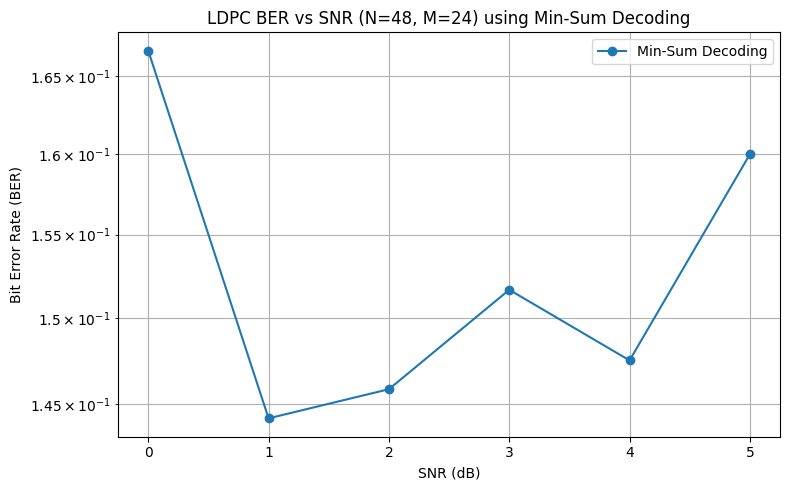

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

# Optimized LDPC functions (reusing matrix, decoding vectorized)
def generate_ldpc_matrix(N, M, column_weight=3):
    H = np.zeros((M, N), dtype=int)
    for col in range(N):
        ones = np.random.choice(M, column_weight, replace=False)
        H[ones, col] = 1
    return H

def ldpc_encode(H, u):
    M, N = H.shape
    K = N - M
    H1 = H[:, :K]
    H2 = H[:, K:]
    try:
        P = np.linalg.pinv(H1) @ H2
    except np.linalg.LinAlgError:
        raise ValueError("Matrix H1 is not invertible")
    G = np.hstack([np.eye(K, dtype=int), P]) % 2
    return (u @ G % 2).astype(int)

def min_sum_decode(H, y_llr, max_iters=30):
    M, N = H.shape
    H_csr = csr_matrix(H)
    Lq = np.tile(y_llr, (M, 1)) * H
    Lr = np.zeros((M, N))

    for _ in range(max_iters):
        for m in range(M):
            indices = H_csr[m].indices
            for n in indices:
                others = [j for j in indices if j != n]
                signs = np.sign(Lq[m, others])
                values = np.abs(Lq[m, others])
                if len(values) == 0:
                    continue
                min_val = np.min(values)
                prod_sign = np.prod(signs)
                Lr[m, n] = prod_sign * min_val

        for n in range(N):
            indices = H_csr[:, n].indices
            Lq[indices, n] = y_llr[n] + np.sum(Lr[indices, n], axis=0)

        L_posterior = y_llr + np.sum(Lr, axis=0)
        decoded = (L_posterior < 0).astype(int)
        if np.all((H @ decoded) % 2 == 0):
            return decoded[:N - M], True

    return decoded[:N - M], False

def simulate_ber_ldpc_optimized(N=48, M=24, snr_db_range=np.arange(0, 6, 1), num_trials=50):
    K = N - M
    H = generate_ldpc_matrix(N, M)
    ber = []

    for snr_db in snr_db_range:
        errors = 0
        total_bits = 0
        snr = 10 ** (snr_db / 10)
        noise_std = np.sqrt(1 / (2 * snr))

        for _ in range(num_trials):
            u = np.random.randint(0, 2, K)
            c = ldpc_encode(H, u)

            tx = 1 - 2 * c
            rx = tx + noise_std * np.random.randn(N)
            rx_llr = 2 * rx / (noise_std ** 2)

            decoded, success = min_sum_decode(H, rx_llr)
            errors += np.sum(u != decoded)
            total_bits += K

        ber.append(errors / total_bits)

    return snr_db_range, ber

# Run optimized simulation
snr_vals, ber_vals = simulate_ber_ldpc_optimized()

# Plot BER vs. SNR
plt.figure(figsize=(8, 5))
plt.semilogy(snr_vals, ber_vals, marker='o', linestyle='-', label="Min-Sum Decoding")
plt.grid(True, which='both')
plt.xlabel("SNR (dB)")
plt.ylabel("Bit Error Rate (BER)")
plt.title("LDPC BER vs SNR (N=48, M=24) using Min-Sum Decoding")
plt.legend()
plt.tight_layout()
plt.show()


# MIMO 

MIMO is a wireless communication technique that uses **multiple transmit (Tx)** and **multiple receive (Rx)** antennas to improve:

* **Spectral efficiency** (more data per unit bandwidth)
* **Link reliability** (through diversity)
* **Capacity** via spatial multiplexing

MIMO is a foundational technology in 4G (LTE), 5G, and Wi-Fi standards.

## **MIMO Channel Model**

Consider a flat-fading MIMO system with:

* $N_t$: Number of transmit antennas
* $N_r$: Number of receive antennas
* $\mathbf{x} \in \mathbb{C}^{N_t \times 1}$: Transmit symbol vector
* $\mathbf{y} \in \mathbb{C}^{N_r \times 1}$: Received symbol vector
* $\mathbf{H} \in \mathbb{C}^{N_r \times N_t}$: Channel matrix
* $\mathbf{n} \in \mathbb{C}^{N_r \times 1}$: AWGN vector

The input-output relationship is:

$$
\mathbf{y} = \mathbf{H} \mathbf{x} + \mathbf{n}
$$

Where:

* $\mathbf{H}_{i,j} \sim \mathcal{CN}(0,1)$ for Rayleigh fading
* $\mathbf{n} \sim \mathcal{CN}(\mathbf{0}, \sigma^2 \mathbf{I})$

## **Types of MIMO Techniques**

### a) **Spatial Diversity (MISO/MIMO)**

Used to improve reliability via **transmit diversity** (e.g., Alamouti coding) or **receive diversity**.

* **Alamouti (2x1)**: Space-time block code that provides full diversity with simple decoding

$$
\mathbf{X} = 
\begin{bmatrix}
x_1 & -x_2^* \\
x_2 & x_1^*
\end{bmatrix}
$$

### b) **Spatial Multiplexing**

Used to **increase capacity** by transmitting **independent data streams** simultaneously from different antennas.

If $\mathbf{H}$ has full rank and $N_r \geq N_t$, we can decode all streams:

$$
\mathbf{x} = \mathbf{H}^\dagger \mathbf{y}
$$

### c) **Beamforming (Pre-coding)**

Used to **steer energy** toward desired directions using Channel State Information (CSI):

$$
\mathbf{x} = \mathbf{w} s, \quad \text{where } \mathbf{w} \in \mathbb{C}^{N_t}
$$


## **Channel Capacity of MIMO**

For an i.i.d. Rayleigh channel, the **ergodic capacity** of a MIMO system with full CSI at receiver is:

$$
C = \mathbb{E} \left[ \log_2 \det \left( \mathbf{I}_{N_r} + \frac{\rho}{N_t} \mathbf{H} \mathbf{H}^\dagger \right) \right] \quad \text{(bps/Hz)}
$$

Where:

* $\rho$: Average SNR
* $\mathbf{H} \mathbf{H}^\dagger$: Gram matrix (positive semi-definite)


## **MIMO Detection Techniques**

To recover $\mathbf{x}$ from $\mathbf{y}$:

### a) **Zero-Forcing (ZF)**

$$
\hat{\mathbf{x}} = (\mathbf{H}^H \mathbf{H})^{-1} \mathbf{H}^H \mathbf{y}
$$

### b) **Minimum Mean Square Error (MMSE)**

$$
\hat{\mathbf{x}} = \left( \mathbf{H}^H \mathbf{H} + \sigma^2 \mathbf{I} \right)^{-1} \mathbf{H}^H \mathbf{y}
$$

### c) **Successive Interference Cancellation (SIC)**

Used in **V-BLAST** architectures: detect strongest stream first, subtract its contribution, repeat.


## **MIMO in 3GPP and 5G**

* 4G LTE: Up to 4x4 MIMO
* 5G NR: Up to 8x8 and **massive MIMO** (64 or more antennas at the base station)
* Uses **hybrid beamforming**, **CSI-RS** for feedback, and **codebook-based precoding**

---



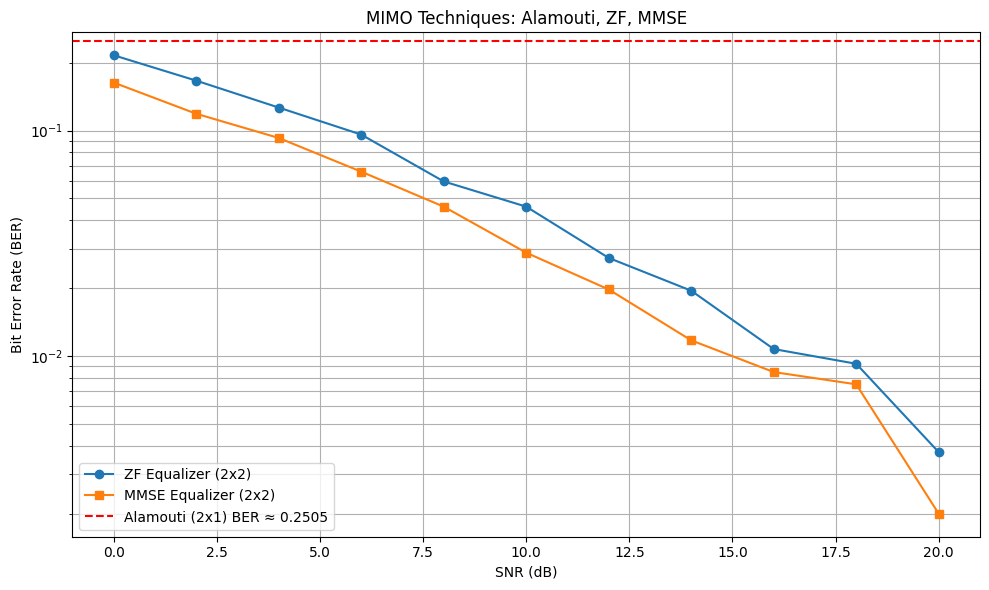

In [127]:
# ---------- Alamouti (2x1) STBC Simulation ----------
def simulate_alamouti(num_symbols=1000, snr_db=10):
    s1 = np.random.choice([-1, 1], num_symbols) + 1j * np.random.choice([-1, 1], num_symbols)
    s2 = np.random.choice([-1, 1], num_symbols) + 1j * np.random.choice([-1, 1], num_symbols)

    x1 = s1
    x2 = s2
    X = np.vstack([x1, -np.conj(x2), x2, np.conj(x1)]).T.reshape(-1, 2)

    h1 = (np.random.randn(num_symbols) + 1j * np.random.randn(num_symbols)) / np.sqrt(2)
    h2 = (np.random.randn(num_symbols) + 1j * np.random.randn(num_symbols)) / np.sqrt(2)

    y = []
    noise_std = np.sqrt(1 / (2 * 10**(snr_db/10)))

    for i in range(num_symbols):
        h = np.array([[h1[i]], [h2[i]]])
        xi = X[2*i:2*i+2]
        yi = xi @ h + noise_std * (np.random.randn(2, 1) + 1j * np.random.randn(2, 1))
        y.append(yi.flatten())

    y = np.array(y)
    y1, y2 = y[:, 0], y[:, 1]

    s1_hat = np.conj(h1)*y1 + h2*np.conj(y2)
    s2_hat = np.conj(h2)*y1 - h1*np.conj(y2)
    s1_hat /= np.abs(h1)**2 + np.abs(h2)**2
    s2_hat /= np.abs(h1)**2 + np.abs(h2)**2

    err1 = np.sum(np.sign(s1.real) != np.sign(s1_hat.real)) + np.sum(np.sign(s1.imag) != np.sign(s1_hat.imag))
    err2 = np.sum(np.sign(s2.real) != np.sign(s2_hat.real)) + np.sum(np.sign(s2.imag) != np.sign(s2_hat.imag))

    ber = (err1 + err2) / (2 * num_symbols * 2)
    return ber

# ---------- Spatial Multiplexing with ZF and MMSE ----------
def simulate_mimo_zf_mmse(Nt=2, Nr=2, snr_db_range=range(0, 21, 2), num_trials=1000):
    ber_zf = []
    ber_mmse = []

    for snr_db in snr_db_range:
        errors_zf = 0
        errors_mmse = 0
        total_bits = 0
        noise_var = 1 / (10 ** (snr_db / 10))

        for _ in range(num_trials):
            x = (np.random.choice([-1, 1], Nt) + 1j * np.random.choice([-1, 1], Nt)) / np.sqrt(2)
            H = (np.random.randn(Nr, Nt) + 1j * np.random.randn(Nr, Nt)) / np.sqrt(2)
            noise = np.sqrt(noise_var / 2) * (np.random.randn(Nr) + 1j * np.random.randn(Nr))
            y = H @ x + noise

            H_zf = np.linalg.pinv(H)
            x_hat_zf = H_zf @ y

            HhH = H.conj().T @ H
            W_mmse = np.linalg.inv(HhH + noise_var * np.eye(Nt)) @ H.conj().T
            x_hat_mmse = W_mmse @ y

            errors_zf += np.sum(np.sign(x.real) != np.sign(x_hat_zf.real)) + \
                         np.sum(np.sign(x.imag) != np.sign(x_hat_zf.imag))
            errors_mmse += np.sum(np.sign(x.real) != np.sign(x_hat_mmse.real)) + \
                           np.sum(np.sign(x.imag) != np.sign(x_hat_mmse.imag))
            total_bits += 2 * Nt

        ber_zf.append(errors_zf / total_bits)
        ber_mmse.append(errors_mmse / total_bits)

    return snr_db_range, ber_zf, ber_mmse

# ---------- Run and Plot ----------
ber_alamouti = simulate_alamouti()
snrs, ber_zf, ber_mmse = simulate_mimo_zf_mmse()

plt.figure(figsize=(10, 6))
plt.semilogy(snrs, ber_zf, 'o-', label='ZF Equalizer (2x2)')
plt.semilogy(snrs, ber_mmse, 's-', label='MMSE Equalizer (2x2)')
plt.axhline(ber_alamouti, color='red', linestyle='--', label=f'Alamouti (2x1) BER ≈ {ber_alamouti:.4f}')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.grid(True, which='both')
plt.title('MIMO Techniques: Alamouti, ZF, MMSE')
plt.legend()
plt.tight_layout()
plt.show()


# **Beamforming: Theory and Mathematical Foundation**

**Beamforming** is a signal processing technique used in antenna arrays to direct the transmitted or received signal energy in specific spatial directions. Instead of radiating energy in all directions (omnidirectionally), beamforming enables:

* Increased **signal strength** at desired receivers
* Suppression of **interference** from undesired directions
* Improved **link reliability** and **spectral efficiency**

Beamforming is fundamental in:

* **Massive MIMO**
* **5G NR**
* **mmWave systems**
* **Radar and sonar arrays**

## **Beamforming Architecture**

There are three main types:

| Type        | Description                            | Hardware Requirements       |
| ----------- | -------------------------------------- | --------------------------- |
| **Analog**  | Single RF chain with phase shifters    | Low complexity, low cost    |
| **Digital** | One RF chain per antenna               | High flexibility, high cost |
| **Hybrid**  | Combines analog + digital (used in 5G) | Balanced performance/cost   |



## **Mathematical Model (Transmit Beamforming)**

Assume:

* $N_t$: Number of transmit antennas
* $\mathbf{h} \in \mathbb{C}^{N_t \times 1}$: Channel vector (Tx → Rx)
* $s$: Transmit symbol (scalar)
* $\mathbf{w} \in \mathbb{C}^{N_t \times 1}$: Beamforming weight vector (precoder)
* $\mathbf{x} = \mathbf{w}s$: Transmit signal
* $y$: Received signal
* $n \sim \mathcal{CN}(0, \sigma^2)$: AWGN noise

Then, the received signal is:

$$
y = \mathbf{h}^H \mathbf{w} s + n
$$

* $\mathbf{h}^H \mathbf{w}$: **Effective channel gain**
* The objective: **choose** $\mathbf{w}$ to **maximize SNR**

## **Beamforming Weight Design**

### a) **Maximum Ratio Transmission (MRT)** – for downlink

Choose:

$$
\mathbf{w} = \frac{\mathbf{h}}{\|\mathbf{h}\|}
$$

Then:

$$
y = \|\mathbf{h}\| s + n
$$

* This aligns the beam with the channel direction (matched filter).
* Maximizes received signal power.


### b) **Zero-Forcing Beamforming (ZF)** – for multi-user

Let $\mathbf{H} = [\mathbf{h}_1, \dots, \mathbf{h}_K]^H \in \mathbb{C}^{K \times N_t}$

ZF precoder:

$$
\mathbf{W}_{ZF} = \mathbf{H}^H \left(\mathbf{H} \mathbf{H}^H \right)^{-1}
$$

* Used in **multi-user MIMO** to eliminate inter-user interference.


### c) **Minimum Mean Square Error (MMSE) Beamforming**

Balances between interference cancellation and noise suppression:

$$
\mathbf{W}_{MMSE} = \mathbf{H}^H \left(\mathbf{H} \mathbf{H}^H + \sigma^2 \mathbf{I} \right)^{-1}
$$

* Performs better than ZF in low SNR regimes.


## **Beamforming in 5G NR**

* **CSI-RS (Channel State Information - Reference Signals)** are used for channel estimation.
* **Codebook-based beamforming**: UE feeds back best beam index.
* **Hybrid beamforming** used in mmWave to reduce RF chain count.

## **Receive Beamforming (Combining)**

For uplink (receiver side):

$$
\hat{s} = \mathbf{w}^H \mathbf{y}
$$

Where:

* $\mathbf{y} = \mathbf{h}s + \mathbf{n}$
* $\mathbf{w}$ can be MRT, ZF, or MMSE combiner

## **Array Response Vector**

For a **uniform linear array (ULA)** with spacing $d$, wavelength $\lambda$, angle $\theta$:

$$
\mathbf{a}(\theta) = \left[ 1, e^{j\frac{2\pi d}{\lambda} \sin\theta}, \dots, e^{j\frac{2\pi d}{\lambda}(N_t - 1)\sin\theta} \right]^T
$$

Used in **analog beamforming** and **directional scanning**.

---


| Strategy | Purpose                       | Formula                                                                          |
| -------- | ----------------------------- | -------------------------------------------------------------------------------- |
| **MRT**  | Maximize SNR                  | $\mathbf{w} = \frac{\mathbf{h}}{\|\mathbf{h}\|}$                                 |
| **ZF**   | Null interference             | $\mathbf{W} = \mathbf{H}^H (\mathbf{H} \mathbf{H}^H)^{-1}$                       |
| **MMSE** | Interference + noise tradeoff | $\mathbf{W} = \mathbf{H}^H (\mathbf{H} \mathbf{H}^H + \sigma^2 \mathbf{I})^{-1}$ |

---




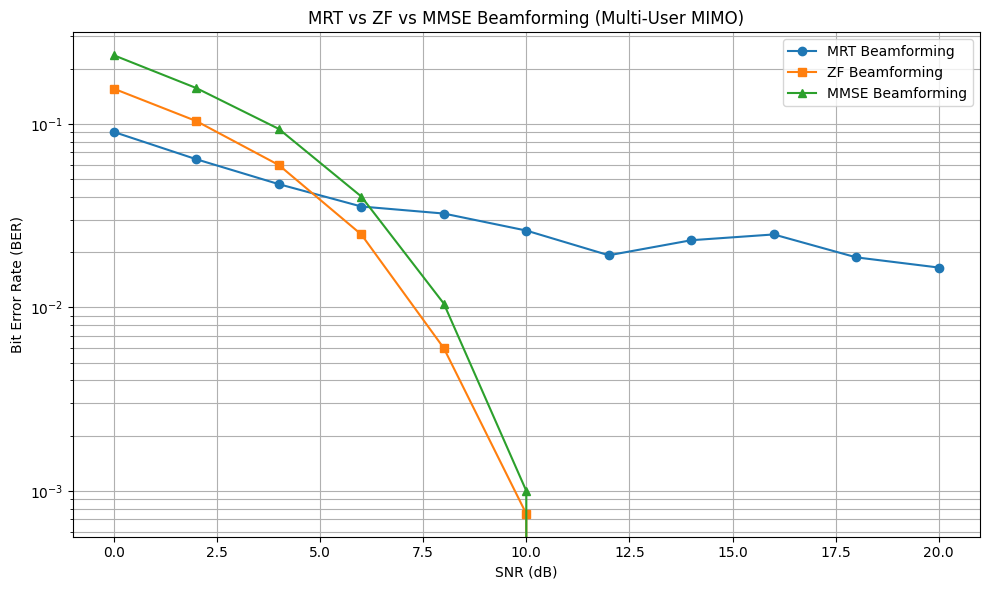

In [129]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_mrt_zf_mmse_beamforming(K=2, Nt=4, snr_db_range=range(0, 21, 2), num_trials=1000):
    """
    Simulate MRT, ZF, and MMSE beamforming in a multi-user MIMO downlink system.

    Parameters:
        K: Number of users (receivers)
        Nt: Number of transmit antennas
        snr_db_range: List or range of SNR values in dB
        num_trials: Monte Carlo trials per SNR point

    Returns:
        snr_db_range: List of SNR values
        ber_mrt: Bit error rate for MRT
        ber_zf: Bit error rate for ZF
        ber_mmse: Bit error rate for MMSE
    """
    ber_mrt = []
    ber_zf = []
    ber_mmse = []

    for snr_db in snr_db_range:
        snr_linear = 10 ** (snr_db / 10)
        noise_var = 1 / snr_linear
        errors_mrt = 0
        errors_zf = 0
        errors_mmse = 0
        total_bits = 0

        for _ in range(num_trials):
            # QPSK symbol vector for each user
            s = (np.random.choice([-1, 1], K) + 1j * np.random.choice([-1, 1], K)) / np.sqrt(2)

            # Channel matrix (K x Nt)
            H = (np.random.randn(K, Nt) + 1j * np.random.randn(K, Nt)) / np.sqrt(2)

            # MRT beamforming
            W_mrt = H.conj().T
            W_mrt /= np.linalg.norm(W_mrt, axis=0, keepdims=True)
            x_mrt = W_mrt @ s
            y_mrt = H @ x_mrt + np.sqrt(noise_var / 2) * (np.random.randn(K) + 1j * np.random.randn(K))
            s_hat_mrt = y_mrt  # No Rx processing

            # ZF beamforming
            W_zf = H.conj().T @ np.linalg.inv(H @ H.conj().T)
            x_zf = W_zf @ s
            y_zf = H @ x_zf + np.sqrt(noise_var / 2) * (np.random.randn(K) + 1j * np.random.randn(K))
            s_hat_zf = y_zf

            # MMSE beamforming
            W_mmse = H.conj().T @ np.linalg.inv(H @ H.conj().T + noise_var * np.eye(K))
            x_mmse = W_mmse @ s
            y_mmse = H @ x_mmse + np.sqrt(noise_var / 2) * (np.random.randn(K) + 1j * np.random.randn(K))
            s_hat_mmse = y_mmse

            # Decision and error counting
            errors_mrt += np.sum(np.sign(s.real) != np.sign(s_hat_mrt.real)) + \
                          np.sum(np.sign(s.imag) != np.sign(s_hat_mrt.imag))
            errors_zf += np.sum(np.sign(s.real) != np.sign(s_hat_zf.real)) + \
                         np.sum(np.sign(s.imag) != np.sign(s_hat_zf.imag))
            errors_mmse += np.sum(np.sign(s.real) != np.sign(s_hat_mmse.real)) + \
                           np.sum(np.sign(s.imag) != np.sign(s_hat_mmse.imag))

            total_bits += 2 * K

        ber_mrt.append(errors_mrt / total_bits)
        ber_zf.append(errors_zf / total_bits)
        ber_mmse.append(errors_mmse / total_bits)

    return snr_db_range, ber_mrt, ber_zf, ber_mmse


# ---------- Run Simulation ----------
snrs, ber_mrt, ber_zf, ber_mmse = simulate_mrt_zf_mmse_beamforming()

# ---------- Plot ----------
plt.figure(figsize=(10, 6))
plt.semilogy(snrs, ber_mrt, 'o-', label='MRT Beamforming')
plt.semilogy(snrs, ber_zf, 's-', label='ZF Beamforming')
plt.semilogy(snrs, ber_mmse, '^-', label='MMSE Beamforming')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('MRT vs ZF vs MMSE Beamforming (Multi-User MIMO)')
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()


## MIMO + OFDM + Beamforming

1. **Generate OFDM symbols** with QPSK across all subcarriers.
2. **Apply channel $H_k$** and beamforming weights $\mathbf{W}_k$ per subcarrier $k$.
3. **Add AWGN**.
4. **Decode using the same per-subcarrier weights**.
5. **Calculate BER across all subcarriers and OFDM symbols**.


### Assumptions for Simplicity

* OFDM with $N_{\text{sc}}$ subcarriers (e.g. 64)
* Flat fading per subcarrier (i.i.d. channel $H_k \in \mathbb{C}^{K \times N_t}$)
* Same number of users $K$ as before
* One OFDM symbol per simulation run


---
### OFDM Symbol Generation for Multi-User MIMO

We generate QPSK symbols for each user across multiple subcarriers.

* Define $K$: number of users (receivers)
* Define $N_t$: number of transmit antennas
* Define $N_{\text{sc}}$: number of subcarriers
* For each user, generate one QPSK symbol per subcarrier





In [130]:
def generate_ofdm_qpsk_symbols(K, N_sc):
    """
    Generate QPSK symbols per subcarrier for K users over N_sc subcarriers.
    
    Output:
        S: K x N_sc matrix of QPSK symbols
    """
    bits = np.random.randint(0, 2, size=(K, N_sc, 2))
    symbols = (2 * bits[..., 0] - 1) + 1j * (2 * bits[..., 1] - 1)
    symbols /= np.sqrt(2)  # Normalize QPSK power
    return symbols



### Channel and Beamforming per Subcarrier**

For each subcarrier $k \in [0, N_{\text{sc}} - 1]$:

1. Generate a random Rayleigh channel matrix $\mathbf{H}_k \in \mathbb{C}^{K \times N_t}$
2. Compute:

   * **MRT beamformer:** $\mathbf{W}_k^{\text{MRT}} = \mathbf{H}_k^H / \|\mathbf{H}_k^H\|$
   * **ZF beamformer:** $\mathbf{W}_k^{\text{ZF}} = \mathbf{H}_k^H(\mathbf{H}_k \mathbf{H}_k^H)^{-1}$
   * **MMSE beamformer:**

     $$
     \mathbf{W}_k^{\text{MMSE}} = \mathbf{H}_k^H \left(\mathbf{H}_k \mathbf{H}_k^H + \sigma^2 \mathbf{I}\right)^{-1}
     $$

---


In [131]:
def generate_mimo_channels_and_weights(K, Nt, N_sc, snr_db):
    """
    Generate MIMO channels and MRT, ZF, MMSE beamforming weights for each subcarrier.

    Returns:
        H_list: List of H_k ∈ ℂ^{K×Nt}
        W_mrt_list, W_zf_list, W_mmse_list: beamforming weights per subcarrier
    """
    H_list = []
    W_mrt_list = []
    W_zf_list = []
    W_mmse_list = []

    snr_linear = 10 ** (snr_db / 10)
    noise_var = 1 / snr_linear

    for _ in range(N_sc):
        H = (np.random.randn(K, Nt) + 1j * np.random.randn(K, Nt)) / np.sqrt(2)
        H_list.append(H)

        # MRT
        W_mrt = H.conj().T
        W_mrt /= np.linalg.norm(W_mrt, axis=0, keepdims=True)
        W_mrt_list.append(W_mrt)

        # ZF
        W_zf = H.conj().T @ np.linalg.inv(H @ H.conj().T)
        W_zf_list.append(W_zf)

        # MMSE
        W_mmse = H.conj().T @ np.linalg.inv(H @ H.conj().T + noise_var * np.eye(K))
        W_mmse_list.append(W_mmse)

    return H_list, W_mrt_list, W_zf_list, W_mmse_list

### Apply Beamforming and Simulate MIMO-OFDM Transmission**

For each subcarrier $k$:

1. Use the QPSK symbol vector $\mathbf{s}_k \in \mathbb{C}^{K}$
2. Multiply by beamforming matrix $\mathbf{W}_k \in \mathbb{C}^{N_t \times K}$ to get transmit signal $\mathbf{x}_k = \mathbf{W}_k \cdot \mathbf{s}_k$
3. Pass through the channel $\mathbf{H}_k \in \mathbb{C}^{K \times N_t}$:
   $\mathbf{y}_k = \mathbf{H}_k \cdot \mathbf{x}_k + \mathbf{n}_k$
4. Collect received signals $\mathbf{y}_k$ for all subcarriers



In [132]:
def transmit_through_channel(S, H_list, W_list, snr_db):
    """
    Apply beamforming, channel, and AWGN noise for each subcarrier.

    Inputs:
        S: QPSK symbols, shape (K, N_sc)
        H_list: list of KxNt channel matrices
        W_list: list of Nt x K beamforming matrices
        snr_db: SNR in dB

    Returns:
        Y: received signal matrix, shape (K, N_sc)
    """
    K, N_sc = S.shape
    snr_linear = 10 ** (snr_db / 10)
    noise_var = 1 / snr_linear

    Y = np.zeros((K, N_sc), dtype=complex)

    for k in range(N_sc):
        H_k = H_list[k]
        W_k = W_list[k]
        s_k = S[:, k]  # (K,)
        x_k = W_k @ s_k  # (Nt,)
        noise = np.sqrt(noise_var / 2) * (np.random.randn(K) + 1j * np.random.randn(K))
        y_k = H_k @ x_k + noise
        Y[:, k] = y_k

    return Y

### Decision and BER Calculation**

For each subcarrier:

1. Received signal $\mathbf{y}_k \in \mathbb{C}^K$
2. Original symbol $\mathbf{s}_k \in \mathbb{C}^K$
3. Perform hard decision:

   $$
   \hat{b}_k = \text{sign}(\text{Re}(\mathbf{y}_k)), \quad \text{sign}(\text{Im}(\mathbf{y}_k))
   $$
4. Compare with $\mathbf{s}_k$ to compute bit errors
5. Sum over all users and subcarriers to get total BER




In [133]:
def compute_ber(S_tx, Y_rx):
    """
    Compute bit error rate by comparing transmitted and received QPSK symbols.

    Inputs:
        S_tx: Transmitted QPSK symbols, shape (K, N_sc)
        Y_rx: Received QPSK symbols, shape (K, N_sc)

    Returns:
        BER (bit error rate)
    """
    bits_tx_real = np.sign(S_tx.real)
    bits_tx_imag = np.sign(S_tx.imag)
    bits_rx_real = np.sign(Y_rx.real)
    bits_rx_imag = np.sign(Y_rx.imag)

    errors = np.sum(bits_tx_real != bits_rx_real) + np.sum(bits_tx_imag != bits_rx_imag)
    total_bits = 2 * S_tx.size

    return errors / total_bits